In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import weightstats as stests
from matplotlib import rcParams
plt.rcParams['axes.grid'] = False
mpl.rcParams['pdf.fonttype'] = 42
import vcf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
reader = vcf.Reader(open("/Users/peien/NYU Langone Health Dropbox/Peien Jiang/gDNA/allmerged/all_samples.vcf", 'r'))

rows = []

for rec in reader:
    # for each ALT allele, make a separate row
    for alt_idx, alt_allele in enumerate(rec.ALT):
        base = {
            "POS": rec.POS,
            "REF": rec.REF,
            "ALT": str(alt_allele),
            "QUAL": rec.QUAL,
        }
        for call in rec.samples:
            data = call.data
            ro = getattr(data, "RO", None)
            ao_raw = getattr(data, "AO", None)
            # if AO is a list (one entry per ALT), pick the one matching this allele
            if isinstance(ao_raw, (list, tuple)):
                ao = ao_raw[alt_idx]
            else:
                ao = ao_raw
            base[f"{call.sample}_RO"] = ro
            base[f"{call.sample}_AO"] = ao

        rows.append(base)

df = pd.DataFrame(rows)
df

,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,14_RO,14_AO,8_RO,8_AO,16_RO,16_AO,19_RO,19_AO,17_RO,17_AO
0,317,A,G,3.429810e+06,0.0,4809.0,0,4819,2.0,4635.0,...,1,3988,0.0,5328.0,0.0,4638.0,0.0,5199.0,1.0,4332.0
1,5010,C,G,3.577330e+06,0.0,5029.0,0,5119,0.0,4867.0,...,0,3998,2.0,5615.0,0.0,4665.0,0.0,5591.0,0.0,4345.0
2,12743,A,C,0.000000e+00,2500.0,490.0,2535,573,2430.0,447.0,...,2051,399,3028.0,489.0,2505.0,458.0,2959.0,498.0,2366.0,410.0
3,12750,A,C,7.251740e-12,2944.0,200.0,3018,260,2885.0,191.0,...,2444,179,3595.0,241.0,2981.0,196.0,3502.0,226.0,2817.0,180.0
4,13778,A,C,0.000000e+00,2955.0,331.0,2885,337,2773.0,283.0,...,2450,250,3335.0,357.0,2936.0,314.0,3295.0,350.0,2682.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,2339.0,124.0,2379,110,2354.0,101.0,...,1850,100,2300.0,100.0,2137.0,116.0,2213.0,120.0,1919.0,110.0
461,2846904,A,C,1.172620e-11,2222.0,475.0,2221,478,2158.0,481.0,...,1749,387,2104.0,501.0,1984.0,472.0,2046.0,492.0,1737.0,420.0
462,2846907,T,C,0.000000e+00,2477.0,184.0,2494,201,2446.0,193.0,...,1974,159,2429.0,201.0,2260.0,183.0,2306.0,192.0,1999.0,161.0
463,2858553,A,C,0.000000e+00,3572.0,158.0,3529,189,3448.0,134.0,...,2733,132,3596.0,119.0,3175.0,137.0,3377.0,136.0,2942.0,82.0


In [3]:
#CHeck the case of multiple ALT alleles
df[df['POS']==2605526]


,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,14_RO,14_AO,8_RO,8_AO,16_RO,16_AO,19_RO,19_AO,17_RO,17_AO
419,2605526,ATCTA,CTCTC,2.058260e-11,2123.0,724.0,2140,749,2096.0,701.0,...,1758,645,2064.0,623.0,2057.0,723.0,1960.0,616.0,1931.0,631.0
420,2605526,ATCTA,CTCTA,2.058260e-11,2123.0,154.0,2140,150,2096.0,130.0,...,1758,117,2064.0,140.0,2057.0,162.0,1960.0,140.0,1931.0,140.0


In [3]:
samples = [col[:-3] for col in df.columns if col.endswith('_RO')]
# for each sample, add a new “<sample>_ratio” column
for sample in samples:
    ro_col = f"{sample}_RO"
    ao_col = f"{sample}_AO"
    ratio_col = f"{sample}_ratio"
    # guard against division by zero if desired
    df[ratio_col] = df[ao_col] / (df[ao_col] + df[ro_col])
df

,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,18_ratio,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio
0,317,A,G,3.429810e+06,0.0,4809.0,0,4819,2.0,4635.0,...,1.000000,1.000000,1.000000,1.000000,0.999497,0.999749,1.000000,1.000000,1.000000,0.999769
1,5010,C,G,3.577330e+06,0.0,5029.0,0,5119,0.0,4867.0,...,1.000000,0.999828,1.000000,1.000000,1.000000,1.000000,0.999644,1.000000,1.000000,1.000000
2,12743,A,C,0.000000e+00,2500.0,490.0,2535,573,2430.0,447.0,...,0.149586,0.160271,0.161889,0.164246,0.150166,0.162857,0.139039,0.154573,0.144056,0.147695
3,12750,A,C,7.251740e-12,2944.0,200.0,3018,260,2885.0,191.0,...,0.057790,0.063981,0.065303,0.075836,0.064504,0.068242,0.062826,0.061693,0.060622,0.060060
4,13778,A,C,0.000000e+00,2955.0,331.0,2885,337,2773.0,283.0,...,0.087963,0.105521,0.099138,0.104553,0.105851,0.092593,0.096696,0.096615,0.096022,0.087134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,2339.0,124.0,2379,110,2354.0,101.0,...,0.046268,0.052863,0.041985,0.060619,0.048534,0.051282,0.041667,0.051487,0.051436,0.054214
461,2846904,A,C,1.172620e-11,2222.0,475.0,2221,478,2158.0,481.0,...,0.187120,0.185546,0.169767,0.191552,0.192644,0.181180,0.192322,0.192182,0.193853,0.194715
462,2846907,T,C,0.000000e+00,2477.0,184.0,2494,201,2446.0,193.0,...,0.069106,0.074288,0.062401,0.068354,0.074600,0.074543,0.076426,0.074908,0.076861,0.074537
463,2858553,A,C,0.000000e+00,3572.0,158.0,3529,189,3448.0,134.0,...,0.030434,0.041964,0.039141,0.041133,0.035991,0.046073,0.032032,0.041365,0.038713,0.027116


In [5]:
df = df[df['1_ratio']<0.4]
df

,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,18_ratio,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio
2,12743,A,C,0.000000e+00,2500.0,490.0,2535,573,2430.0,447.0,...,0.149586,0.160271,0.161889,0.164246,0.150166,0.162857,0.139039,0.154573,0.144056,0.147695
3,12750,A,C,7.251740e-12,2944.0,200.0,3018,260,2885.0,191.0,...,0.057790,0.063981,0.065303,0.075836,0.064504,0.068242,0.062826,0.061693,0.060622,0.060060
4,13778,A,C,0.000000e+00,2955.0,331.0,2885,337,2773.0,283.0,...,0.087963,0.105521,0.099138,0.104553,0.105851,0.092593,0.096696,0.096615,0.096022,0.087134
5,33404,A,C,2.079860e-11,2551.0,512.0,2605,531,2440.0,548.0,...,0.177616,0.185094,0.177086,0.189069,0.183524,0.188758,0.188512,0.184123,0.186418,0.181197
6,33414,G,A,3.641300e-12,3115.0,194.0,3137,184,3012.0,164.0,...,0.057563,0.061153,0.057127,0.052299,0.058869,0.048509,0.051079,0.062267,0.057758,0.050600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,2339.0,124.0,2379,110,2354.0,101.0,...,0.046268,0.052863,0.041985,0.060619,0.048534,0.051282,0.041667,0.051487,0.051436,0.054214
461,2846904,A,C,1.172620e-11,2222.0,475.0,2221,478,2158.0,481.0,...,0.187120,0.185546,0.169767,0.191552,0.192644,0.181180,0.192322,0.192182,0.193853,0.194715
462,2846907,T,C,0.000000e+00,2477.0,184.0,2494,201,2446.0,193.0,...,0.069106,0.074288,0.062401,0.068354,0.074600,0.074543,0.076426,0.074908,0.076861,0.074537
463,2858553,A,C,0.000000e+00,3572.0,158.0,3529,189,3448.0,134.0,...,0.030434,0.041964,0.039141,0.041133,0.035991,0.046073,0.032032,0.041365,0.038713,0.027116


## What genes have those mutations?

In [6]:
#Load the gff gene innotation file into a dataframe
colnames = [
    "seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"
]

gff = pd.read_csv(
    "/Users/peien/NYU Langone Health Dropbox/Peien Jiang/gDNA/allmerged/USA300_FPR3757_rRNA_new.gff",
    sep="\t",
    comment="#",
    header=None,
    names=colnames,
    dtype=str
)
# 2) Parse the 9th column (attributes) into a dict per row
def parse_attrs(attr_str):
    d = {}
    for part in attr_str.split(";"):
        if "=" in part:
            key, val = part.split("=", 1)
            d[key] = val
    return d
attr_dicts = gff["attributes"].apply(parse_attrs)

# 3) Turn those dicts into a small DataFrame, and pull out only what you need
attrs_df = pd.DataFrame(attr_dicts.tolist())
# If your file really uses "locus_tag" and "gene":
gff["locus_tag"] = attrs_df.get("locus_tag")
gff["gene"]      = attrs_df.get("gene")
# But if your GFF uses "Name" for the gene symbol, you can do:
if "Name" in attrs_df:
    gff["gene"] = attrs_df["Name"]
#make start and end columns integers
gff["start"] = gff["start"].astype(int)
gff["end"] = gff["end"].astype(int)
gff["gene"].fillna(gff["locus_tag"], inplace=True)
gff

,seqid,source,type,start,end,score,strand,phase,attributes,locus_tag,gene
0,NC_007793.1,RefSeq,generRnatRna,544,1905,.,+,.,ID=gene-SAUSA300_RS00010;Name=dnaA;gbkey=Gene;...,SAUSA300_RS00010,dnaA
1,NC_007793.1,RefSeq,generRnatRna,2183,3316,.,+,.,ID=gene-SAUSA300_RS00015;Name=dnaN;gbkey=Gene;...,SAUSA300_RS00015,dnaN
2,NC_007793.1,RefSeq,generRnatRna,3697,3942,.,+,.,ID=gene-SAUSA300_RS00020;Name=yaaA;gbkey=Gene;...,SAUSA300_RS00020,yaaA
3,NC_007793.1,RefSeq,generRnatRna,3939,5051,.,+,.,ID=gene-SAUSA300_RS00025;Name=recF;gbkey=Gene;...,SAUSA300_RS00025,recF
4,NC_007793.1,RefSeq,generRnatRna,5061,6995,.,+,.,ID=gene-SAUSA300_RS00030;Name=gyrB;gbkey=Gene;...,SAUSA300_RS00030,gyrB
...,...,...,...,...,...,...,...,...,...,...,...
2924,NC_007793.1,custom,generRnatRna,2001081,2001171,.,-,.,locus_tag=pre_rRNA,pre_rRNA,pre_rRNA
2925,NC_007793.1,custom,generRnatRna,2175926,2175997,.,-,.,locus_tag=pre_rRNA,pre_rRNA,pre_rRNA
2926,NC_007793.1,custom,generRnatRna,2178921,2179468,.,-,.,locus_tag=pre_rRNA,pre_rRNA,pre_rRNA
2927,NC_007793.1,custom,generRnatRna,2292480,2292551,.,-,.,locus_tag=pre_rRNA,pre_rRNA,pre_rRNA


In [147]:
gff[gff['gene']=='SAUSA300_RS10125']

,seqid,source,type,start,end,score,strand,phase,attributes,locus_tag,gene
1990,NC_007793.1,RefSeq,generRnatRna,2016041,2016355,.,-,.,ID=gene-SAUSA300_RS10125;Name=SAUSA300_RS10125...,SAUSA300_RS10125,SAUSA300_RS10125


In [7]:
# add the gene information to the mutatiion dataframe to see how it relates to the genes
for index, row in df.iterrows():
    position = row['POS']
    
    # Find genes where the position falls within the start and end range
    matching_genes = gff[(gff['start'] <= position) & (gff['end'] >= position)]

    # Optional: handle the case where multiple genes match or no genes match
    if len(matching_genes) == 1:
        # Assuming 'ID' is the column with gene identifiers
        df.loc[index, 'Gene_ID'] = matching_genes['gene'].iloc[0]
    elif len(matching_genes) > 1:
        # Handle multiple matches, for example, by concatenating gene IDs
        df.loc[index, 'Gene_ID']  = ', '.join(matching_genes['gene'].tolist())
    else:
        # Handle no matches
        df.loc[index, 'Gene_ID'] = 'No Match'

#Display the updated DataFrame
df

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_98850/920078113.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[index, 'Gene_ID'] = matching_genes['gene'].iloc[0]


,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio,Gene_ID
2,12743,A,C,0.000000e+00,2500.0,490.0,2535,573,2430.0,447.0,...,0.160271,0.161889,0.164246,0.150166,0.162857,0.139039,0.154573,0.144056,0.147695,SAUSA300_RS14805
3,12750,A,C,7.251740e-12,2944.0,200.0,3018,260,2885.0,191.0,...,0.063981,0.065303,0.075836,0.064504,0.068242,0.062826,0.061693,0.060622,0.060060,SAUSA300_RS14805
4,13778,A,C,0.000000e+00,2955.0,331.0,2885,337,2773.0,283.0,...,0.105521,0.099138,0.104553,0.105851,0.092593,0.096696,0.096615,0.096022,0.087134,"serS, SAUSA300_RS14805"
5,33404,A,C,2.079860e-11,2551.0,512.0,2605,531,2440.0,548.0,...,0.185094,0.177086,0.189069,0.183524,0.188758,0.188512,0.184123,0.186418,0.181197,No Match
6,33414,G,A,3.641300e-12,3115.0,194.0,3137,184,3012.0,164.0,...,0.061153,0.057127,0.052299,0.058869,0.048509,0.051079,0.062267,0.057758,0.050600,No Match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,2339.0,124.0,2379,110,2354.0,101.0,...,0.052863,0.041985,0.060619,0.048534,0.051282,0.041667,0.051487,0.051436,0.054214,No Match
461,2846904,A,C,1.172620e-11,2222.0,475.0,2221,478,2158.0,481.0,...,0.185546,0.169767,0.191552,0.192644,0.181180,0.192322,0.192182,0.193853,0.194715,No Match
462,2846907,T,C,0.000000e+00,2477.0,184.0,2494,201,2446.0,193.0,...,0.074288,0.062401,0.068354,0.074600,0.074543,0.076426,0.074908,0.076861,0.074537,No Match
463,2858553,A,C,0.000000e+00,3572.0,158.0,3529,189,3448.0,134.0,...,0.041964,0.039141,0.041133,0.035991,0.046073,0.032032,0.041365,0.038713,0.027116,No Match


In [8]:
df.to_csv("allvcf_gene.csv")

In [2]:
df = pd.read_csv("allvcf_gene.csv", index_col=0)
df

,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio,Gene_ID
2,12743,A,C,0.000000e+00,2500.0,490.0,2535,573,2430.0,447.0,...,0.160271,0.161889,0.164246,0.150166,0.162857,0.139039,0.154573,0.144056,0.147695,SAUSA300_RS14805
3,12750,A,C,7.251740e-12,2944.0,200.0,3018,260,2885.0,191.0,...,0.063981,0.065303,0.075836,0.064504,0.068242,0.062826,0.061693,0.060622,0.060060,SAUSA300_RS14805
4,13778,A,C,0.000000e+00,2955.0,331.0,2885,337,2773.0,283.0,...,0.105521,0.099138,0.104553,0.105851,0.092593,0.096696,0.096615,0.096022,0.087134,"serS, SAUSA300_RS14805"
5,33404,A,C,2.079860e-11,2551.0,512.0,2605,531,2440.0,548.0,...,0.185094,0.177086,0.189069,0.183524,0.188758,0.188512,0.184123,0.186418,0.181197,No Match
6,33414,G,A,3.641300e-12,3115.0,194.0,3137,184,3012.0,164.0,...,0.061153,0.057127,0.052299,0.058869,0.048509,0.051079,0.062267,0.057758,0.050600,No Match
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,2339.0,124.0,2379,110,2354.0,101.0,...,0.052863,0.041985,0.060619,0.048534,0.051282,0.041667,0.051487,0.051436,0.054214,No Match
461,2846904,A,C,1.172620e-11,2222.0,475.0,2221,478,2158.0,481.0,...,0.185546,0.169767,0.191552,0.192644,0.181180,0.192322,0.192182,0.193853,0.194715,No Match
462,2846907,T,C,0.000000e+00,2477.0,184.0,2494,201,2446.0,193.0,...,0.074288,0.062401,0.068354,0.074600,0.074543,0.076426,0.074908,0.076861,0.074537,No Match
463,2858553,A,C,0.000000e+00,3572.0,158.0,3529,189,3448.0,134.0,...,0.041964,0.039141,0.041133,0.035991,0.046073,0.032032,0.041365,0.038713,0.027116,No Match


## Check each evolution experiment individually
### Evolution experiment A, 07/24/23, vcf_12345= 0r,1r,2r,3r,4r,5r

In [3]:
# list the samples you care about
samples = ['1','2','3','4','5']

# build the list of columns you want
meta_cols = ['POS','REF','ALT','QUAL','Gene_ID']
per_sample_cols = []
for s in samples:
    per_sample_cols += [f"{s}_RO", f"{s}_AO", f"{s}_ratio"]

cols = meta_cols + per_sample_cols

# subset
evoA = df[cols].copy()
evoA

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,2_RO,2_AO,2_ratio,3_RO,3_AO,3_ratio,4_RO,4_AO,4_ratio,5_RO,5_AO,5_ratio
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2982.0,576.0,0.161889,2976,568,0.160271,3512,602,0.146330,2693,526,0.163405
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,3564.0,249.0,0.065303,3555,243,0.063981,4119,254,0.058084,3162,277,0.080547
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,3553.0,391.0,0.099138,3467,409,0.105521,4080,434,0.096145,3044,342,0.101004
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2830.0,609.0,0.177086,2646,601,0.185094,2964,692,0.189278,2793,525,0.158228
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3433.0,208.0,0.057127,3224,210,0.061153,3737,223,0.056313,3392,178,0.049860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2259.0,99.0,0.041985,2150,120,0.052863,2685,135,0.047872,2286,133,0.054981
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2098.0,429.0,0.169767,2006,457,0.185546,2497,568,0.185318,2151,466,0.178066
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2359.0,157.0,0.062401,2243,180,0.074288,2808,247,0.080851,2406,189,0.072832
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3535.0,144.0,0.039141,3356,147,0.041964,4172,147,0.034036,3593,161,0.042888


In [17]:
evoA[(evoA['5_ratio']>=0.2)&(evoA['1_ratio']<0.05)]

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,2_RO,2_AO,2_ratio,3_RO,3_AO,3_ratio,4_RO,4_AO,4_ratio,5_RO,5_AO,5_ratio


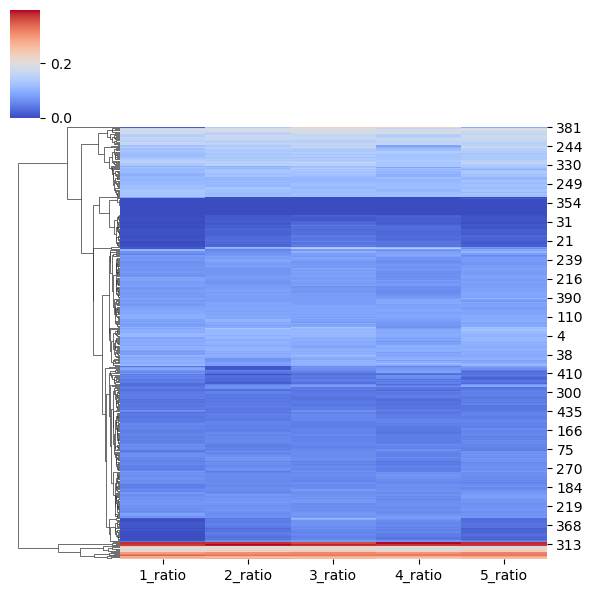

In [39]:
sns.clustermap(evoA[[col for col in evoA.columns if col.endswith('_ratio')]],
               col_cluster=False,
               cmap='coolwarm',
               figsize=(6, 6))
            

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def zavit(df: pd.DataFrame, col_sort: bool = True, row_sort: bool = True) -> pd.DataFrame:
    """
    A dataframe sorting tool for visualization purposes.
    Standardizes the input dataframe, performs PCA, calculates arctangent angles 
    from the first two PCA components, and returns the z-scored dataframe with 
    columns and/or rows sorted by arctangent angles.

    Parameters:
    - df: pd.DataFrame
        Input dataframe with samples as rows and features as columns.
    - col_sort: bool
        If True, sort columns by PCA arctangent angle.
    - row_sort: bool
        If True, sort rows by PCA arctangent angle.

    Returns:
    - pd.DataFrame: z-scored and optionally row/column-sorted dataframe.
    """
    # Z-score normalization
    df_z = pd.DataFrame(
        StandardScaler().fit_transform(df),
        index=df.index,
        columns=df.columns
    )

    # Column-wise PCA for column sorting
    if col_sort:
        pca_cols = PCA(n_components=2)
        _ = pca_cols.fit_transform(df_z)
        col_arctan = pd.DataFrame(
            np.arctan2(pca_cols.components_[0, :], pca_cols.components_[1, :]),
            index=df.columns,
            columns=["arctan"]
        )
        df = df.loc[:, col_arctan.sort_values(by="arctan").index]

    # Row-wise PCA for row sorting (transpose for PCA on rows)
    if row_sort:
        pca_rows = PCA(n_components=2)
        _ = pca_rows.fit_transform(df_z.T)
        row_arctan = pd.DataFrame(
            np.arctan2(pca_rows.components_[0, :], pca_rows.components_[1, :]),
            index=df_z.index,
            columns=["arctan"]
        )
        df = df.loc[row_arctan.sort_values(by="arctan").index, :]

    return df

In [85]:
df_plot = zavit(evoA[[col for col in evoA.columns if col.endswith('_ratio')]],
                  col_sort=False)
df_plot

,1_ratio,2_ratio,3_ratio,4_ratio,5_ratio
247,0.029668,0.050147,0.064067,0.030900,0.072078
176,0.118878,0.134163,0.139294,0.116059,0.143993
432,0.068426,0.079177,0.084050,0.065970,0.075694
363,0.099112,0.123674,0.121149,0.098629,0.123429
419,0.256342,0.277663,0.263889,0.239483,0.258525
...,...,...,...,...,...
212,0.119417,0.147526,0.135224,0.114307,0.146091
263,0.085084,0.112346,0.099099,0.086014,0.110642
277,0.144568,0.168690,0.160188,0.139802,0.173427
200,0.118655,0.129326,0.130487,0.114504,0.129856


In [89]:
evoA.loc[247,:]

POS                    1589499
REF                      GACTG
ALT                      AACCC
QUAL                       0.0
Gene_ID       SAUSA300_RS07840
1_RO                    1112.0
1_AO                      34.0
1_ratio               0.029668
2_RO                    1288.0
2_AO                      68.0
2_ratio               0.050147
3_RO                      1344
3_AO                        92
3_ratio               0.064067
4_RO                      1819
4_AO                        58
4_ratio                 0.0309
5_RO                      1429
5_AO                       111
5_ratio               0.072078
spearman_r                 0.7
spearman_p             0.18812
Name: 247, dtype: object

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_79834/2144188980.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


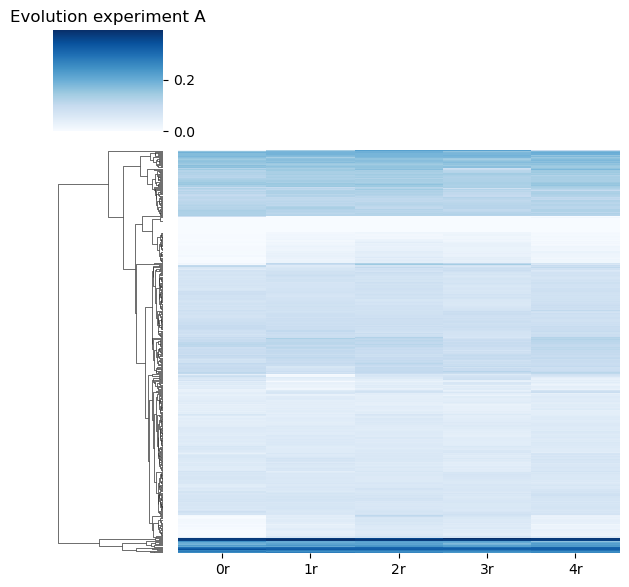

In [117]:
sns.clustermap(evoA[[col for col in evoA.columns if col.endswith('_ratio')]],
               cmap="Blues",
               col_cluster=False,
               yticklabels=False,  
               xticklabels=['0r','1r','2r','3r','4r'], 
               figsize=(6, 6))
plt.grid(False)
plt.title("Evolution experiment A")
plt.tight_layout()
plt.savefig("evoA_all.pdf")

In [34]:
filtered_A = evoA[(evoA['5_ratio'] >= evoA['4_ratio']) &
                        (evoA['4_ratio'] >= evoA['3_ratio']) &
                        (evoA['3_ratio'] >= evoA['2_ratio']) &
                        (evoA['2_ratio'] >= evoA['1_ratio']) &
                        (evoA['5_AO'] >= 5) &
                        (evoA['5_ratio'] > 0)]
filtered_A

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,2_RO,2_AO,...,3_AO,3_ratio,4_RO,4_AO,4_ratio,5_RO,5_AO,5_ratio,spearman_r,spearman_p
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,4308.0,0.0,...,0,0.000000,5080,1,0.000197,4322,55,0.012566,None,None
310,1981217,G,T,5.153370e-12,SAUSA300_RS09840,2056.0,92.0,0.042831,3651.0,188.0,...,191,0.048987,4241,245,0.054614,3027,181,0.056421,None,None
336,2088775,T,G,0.000000e+00,sak,1724.0,84.0,0.046460,1906.0,112.0,...,115,0.057271,2163,148,0.064042,2200,153,0.065023,None,None
420,2605526,ATCTA,CTCTA,2.058260e-11,SAUSA300_RS13390,1407.0,94.0,0.062625,2089.0,140.0,...,139,0.063010,2531,179,0.066052,2131,162,0.070650,None,None


In [4]:
from scipy import stats
def add_spearman_corr_to_df(df, pattern=[1, 2, 3, 4, 5]):
    """
    Add Spearman correlation coefficient and p-value to each row
    comparing the row's ratio values to the provided pattern.
    
    Parameters:
    - df: DataFrame with ratio columns
    - pattern: list or array to correlate against (length must match number of ratio columns)
    
    Returns:
    - df: Original DataFrame with added 'spearman_r' and 'spearman_p' columns
    """
    # Identify ratio columns
    ratio_cols = [col for col in df.columns if col.endswith('_ratio')]
    assert len(ratio_cols) == len(pattern), "Pattern length must match number of ratio columns"
    
    # Initialize result columns
    df['spearman_r'] = None
    df['spearman_p'] = None
    
    for idx, row in df.iterrows():
        if row[ratio_cols].isnull().any():
            continue  # skip rows with NaNs
        
        values = row[ratio_cols].values.astype(float)
        r, p = stats.spearmanr(values, pattern)
        df.at[idx, 'spearman_r'] = r
        df.at[idx, 'spearman_p'] = p

    return df

In [20]:
evoA = add_spearman_corr_to_df(evoA, pattern=[1, 2, 3, 4, 5])
evoA

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,2_RO,2_AO,...,3_AO,3_ratio,4_RO,4_AO,4_ratio,5_RO,5_AO,5_ratio,spearman_r,spearman_p
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2982.0,576.0,...,568,0.160271,3512,602,0.146330,2693,526,0.163405,0.3,0.623838
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,3564.0,249.0,...,243,0.063981,4119,254,0.058084,3162,277,0.080547,0.1,0.872889
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,3553.0,391.0,...,409,0.105521,4080,434,0.096145,3044,342,0.101004,-0.5,0.391002
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2830.0,609.0,...,601,0.185094,2964,692,0.189278,2793,525,0.158228,0.0,1.0
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3433.0,208.0,...,210,0.061153,3737,223,0.056313,3392,178,0.049860,-0.9,0.037386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2259.0,99.0,...,120,0.052863,2685,135,0.047872,2286,133,0.054981,0.9,0.037386
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2098.0,429.0,...,457,0.185546,2497,568,0.185318,2151,466,0.178066,0.1,0.872889
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2359.0,157.0,...,180,0.074288,2808,247,0.080851,2406,189,0.072832,0.6,0.284757
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3535.0,144.0,...,147,0.041964,4172,147,0.034036,3593,161,0.042888,0.4,0.504632


In [62]:
evoA_sig = evoA[(evoA['spearman_p']<0.05)&(evoA['spearman_r']>0)&(evoA['1_ratio']<0.05)]
evoA_sig

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,2_RO,2_AO,...,3_AO,3_ratio,4_RO,4_AO,4_ratio,5_RO,5_AO,5_ratio,spearman_r,spearman_p
39,273576,A,C,3.811020e-12,SAUSA300_RS01205,1662.0,83.0,0.047564,2710.0,155.0,...,161,0.057851,2792,188,0.063087,2679,171,0.060000,0.9,0.037386
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,4755.0,0.0,...,0,0.000000,5477,1,0.000183,4879,4,0.000819,0.894427,0.040519
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,4308.0,0.0,...,0,0.000000,5080,1,0.000197,4322,55,0.012566,0.894427,0.040519
310,1981217,G,T,5.153370e-12,SAUSA300_RS09840,2056.0,92.0,0.042831,3651.0,188.0,...,191,0.048987,4241,245,0.054614,3027,181,0.056421,1.0,0.0
336,2088775,T,G,0.000000e+00,sak,1724.0,84.0,0.046460,1906.0,112.0,...,115,0.057271,2163,148,0.064042,2200,153,0.065023,1.0,0.0
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2259.0,99.0,...,120,0.052863,2685,135,0.047872,2286,133,0.054981,0.9,0.037386


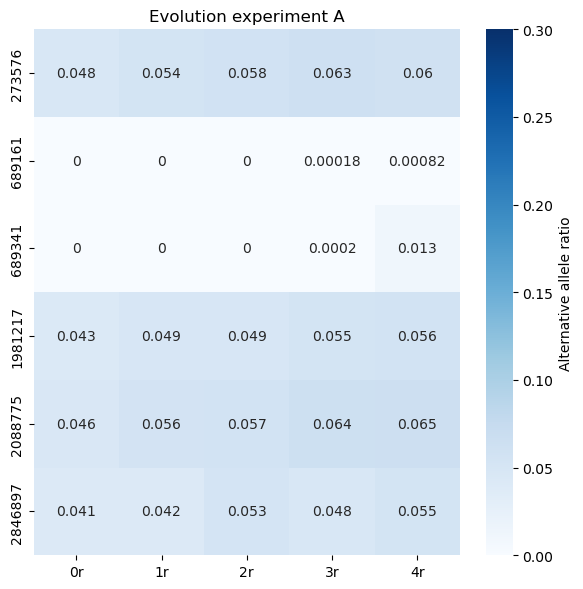

In [70]:
plt.figure(figsize = (6,6))
sns.heatmap(evoA_sig[[col for col in evoA_sig.columns if col.endswith('_ratio')]],
             yticklabels=evoA_sig['POS'],       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            vmax=0.3,
            annot=True,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment A")
plt.tight_layout()
plt.savefig("evoA_corr_sig.pdf")

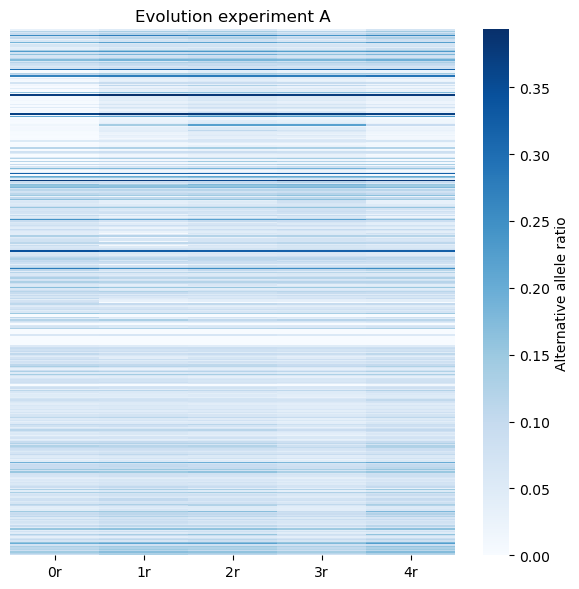

In [107]:
plt.figure(figsize = (6,6))
sns.heatmap(zavit(evoA[[col for col in evoA.columns if col.endswith('_ratio')]],
                  col_sort=False), 
             yticklabels=False,       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment A")
plt.tight_layout()
plt.savefig("evoA_all_zavit.pdf")

In [154]:
evoA[evoA['POS']==2016007]

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,2_RO,2_AO,...,3_AO,3_ratio,4_RO,4_AO,4_ratio,5_RO,5_AO,5_ratio,spearman_r,spearman_p
330,2016007,A,C,0.0,SAUSA300_RS10120,1331.0,203.0,0.132334,2309.0,413.0,...,410,0.148228,2632,397,0.131066,2261,364,0.138667,-0.2,0.74706


In [35]:
df_print = filtered_A

# the timepoints you want on the x‑axis
samples    = [1, 2, 3, 4, 5]
ro_cols    = [f"{s}_RO"    for s in samples]
ao_cols    = [f"{s}_AO"    for s in samples]
ratio_cols = [f"{s}_ratio" for s in samples]

with PdfPages('evoA_filtered_stacked_bar_plots.pdf') as pdf:
    # iterate df_print instead of df
    for _, row in df_print.iterrows():
        fig, ax = plt.subplots()
        x     = list(range(len(samples)))
        ro    = [row[c] for c in ro_cols]
        ao    = [row[c] for c in ao_cols]
        freq  = [row[c] for c in ratio_cols]
        total = [r + a for r, a in zip(ro, ao)]
        y_off = max(total) * 0.02

        bars_ro = ax.bar(x, ro, color="#9ABDDC")
        bars_ao = ax.bar(x, ao, bottom=ro, color="#FFBE65")

        # counts inside segments
        for i, (r, a) in enumerate(zip(ro, ao)):
            if r>0:
                ax.text(i, r/2,    f"{int(r)}", ha='center', va='center',
                        color="#2F76B5", fontsize=9)
            if a>0:
                ax.text(i, r + a/2, f"{int(a)}", ha='center', va='center',
                        color="#A4791D", fontsize=9)

        # frequency above stack
        for i, (tot, f) in enumerate(zip(total, freq)):
            ax.text(i, tot + y_off, f"{f:.5f}", ha='center', va='bottom')

        # expand y‑axis so nothing is clipped
        ax.set_ylim(0, max(total) * 1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(['0r','1r','2r','3r','4r'])
        ax.set_xlabel('Evolution A time point')
        ax.set_ylabel('Read count')
        ax.set_title(f"{row['Gene_ID']} {row['POS']} {row['REF']} → {row['ALT']}")

        # legend outside
        ax.legend((bars_ro[0], bars_ao[0]), ('RO','AO'),
                  loc='upper left', bbox_to_anchor=(1.02,1),
                  frameon=False)
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

### Evolution experiment B, holiday cell experiment
### vcf_678= 2r, 4r, holiday stationary phase

In [6]:
# list the samples you care about
samples = ['1','6','7','8']

# build the list of columns you want
meta_cols = ['POS','REF','ALT','QUAL','Gene_ID']
per_sample_cols = []
for s in samples:
    per_sample_cols += [f"{s}_RO", f"{s}_AO", f"{s}_ratio"]

cols = meta_cols + per_sample_cols

# subset
evoB = df[cols].copy()
evoB

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,8_RO,8_AO,8_ratio
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2430.0,447.0,0.155370,2535,573,0.184363,3028.0,489.0,0.139039
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2885.0,191.0,0.062094,3018,260,0.079317,3595.0,241.0,0.062826
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2773.0,283.0,0.092605,2885,337,0.104593,3335.0,357.0,0.096696
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2440.0,548.0,0.183400,2605,531,0.169324,2557.0,594.0,0.188512
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3012.0,164.0,0.051637,3137,184,0.055405,3121.0,168.0,0.051079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2354.0,101.0,0.041141,2379,110,0.044194,2300.0,100.0,0.041667
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2158.0,481.0,0.182266,2221,478,0.177103,2104.0,501.0,0.192322
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2446.0,193.0,0.073134,2494,201,0.074583,2429.0,201.0,0.076426
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3448.0,134.0,0.037409,3529,189,0.050834,3596.0,119.0,0.032032


In [ ]:
evoB[(evoB['8_ratio']>=0.2)&(evoB['1_ratio']<0.05)]


,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,8_RO,8_AO,8_ratio
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,3773.0,8.0,0.002116,3955,256,0.060793,378.0,2281.0,0.857841
194,1286094,C,T,9.566130e-12,No Match,2810.0,27.0,0.009517,3901.0,8.0,0.002047,4563,15,0.003277,3512.0,973.0,0.216945
215,1445029,C,A,1.103110e+05,SAUSA300_RS07140,2782.0,0.0,0.000000,2399.0,1362.0,0.362138,644,3753,0.853537,2921.0,794.0,0.213728
381,2341508,T,A,0.000000e+00,No Match,2958.0,48.0,0.015968,4241.0,5.0,0.001178,4695,15,0.003185,4158.0,2192.0,0.345197


In [24]:
evoB = add_spearman_corr_to_df(evoB, pattern=[1, 2, 3, 4])
evoB

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,8_RO,8_AO,8_ratio,spearman_r,spearman_p
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2430.0,447.0,0.155370,2535,573,0.184363,3028.0,489.0,0.139039,-0.2,0.8
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2885.0,191.0,0.062094,3018,260,0.079317,3595.0,241.0,0.062826,0.0,1.0
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2773.0,283.0,0.092605,2885,337,0.104593,3335.0,357.0,0.096696,-0.4,0.6
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2440.0,548.0,0.183400,2605,531,0.169324,2557.0,594.0,0.188512,0.4,0.6
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3012.0,164.0,0.051637,3137,184,0.055405,3121.0,168.0,0.051079,-0.8,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2354.0,101.0,0.041141,2379,110,0.044194,2300.0,100.0,0.041667,0.8,0.2
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2158.0,481.0,0.182266,2221,478,0.177103,2104.0,501.0,0.192322,0.4,0.6
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2446.0,193.0,0.073134,2494,201,0.074583,2429.0,201.0,0.076426,1.0,0.0
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3448.0,134.0,0.037409,3529,189,0.050834,3596.0,119.0,0.032032,-0.2,0.8


In [59]:
evoB_sig = evoB[(evoB['spearman_p']<0.05)&(evoB['spearman_r']>0)&(evoB['1_ratio']<0.05)]
evoB_sig

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,8_RO,8_AO,8_ratio,spearman_r,spearman_p
127,689341,CAAAAAATGATGACTA,CAA,62320.3,SAUSA300_RS03310,2794.0,0.0,0.000000,3773.0,8.0,0.002116,3955,256,0.060793,378.0,2281.0,0.857841,1.0,0.0
248,1589504,TT,CC,0.0,SAUSA300_RS07840,1469.0,46.0,0.030363,1786.0,111.0,0.058513,2127,163,0.071179,1575.0,131.0,0.076788,1.0,0.0
266,1743889,G,T,0.0,SAUSA300_RS08670,2936.0,0.0,0.000000,4096.0,1.0,0.000244,4623,2,0.000432,3058.0,678.0,0.181478,1.0,0.0
401,2497443,GAAG,GAAA,0.0,SAUSA300_RS12840,2154.0,94.0,0.041815,2989.0,151.0,0.048089,3178,167,0.049925,3212.0,209.0,0.061093,1.0,0.0


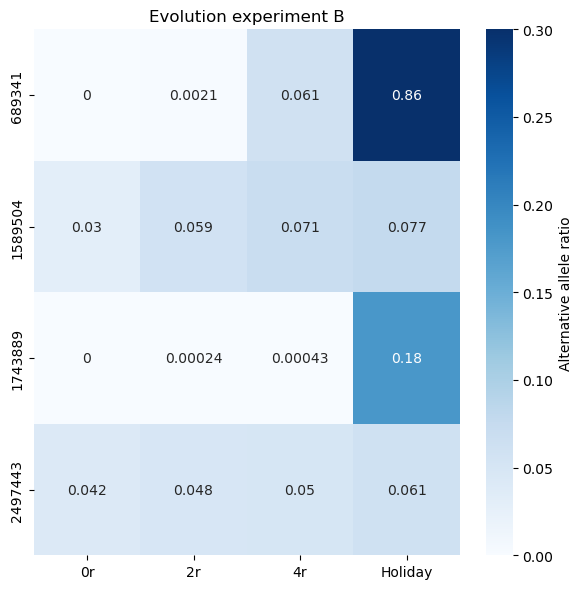

In [71]:
plt.figure(figsize = (6,6))
sns.heatmap(evoB_sig[[col for col in evoB_sig.columns if col.endswith('_ratio')]],
             yticklabels=evoB_sig['POS'],       
             xticklabels=['0r','2r','4r','Holiday'],  
            cmap="Blues",
            vmax=0.3,
            annot=True,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment B")
plt.tight_layout()
plt.savefig("evoB_corr_sig.pdf")

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_79834/897901629.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


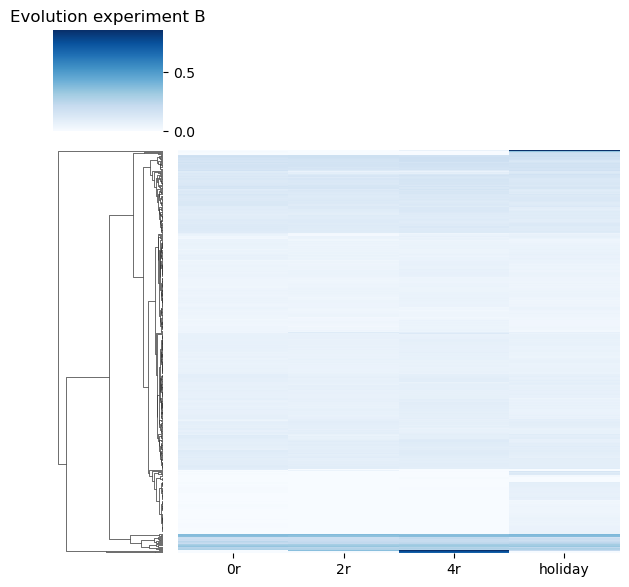

In [119]:
sns.clustermap(evoB[[col for col in evoB.columns if col.endswith('_ratio')]],
               cmap="Blues",
               col_cluster=False,
               yticklabels=False,  
               xticklabels=['0r','2r','4r','holiday'], 
               figsize=(6, 6))
plt.grid(False)
plt.title("Evolution experiment B")
plt.tight_layout()
plt.savefig("evoB_all.pdf")

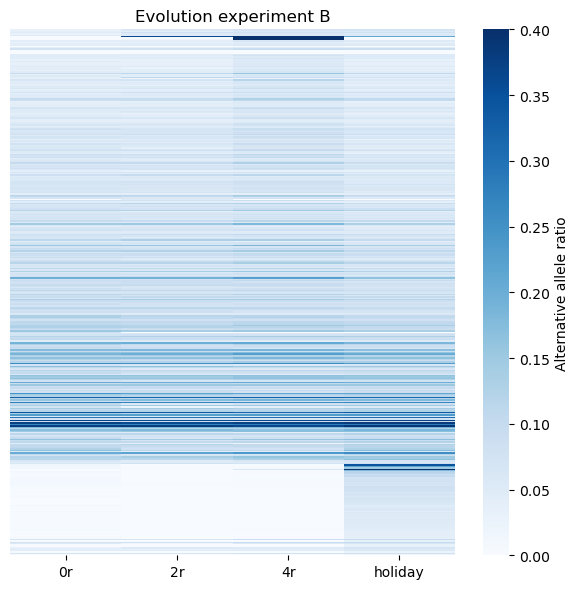

In [106]:
plt.figure(figsize = (6,6))
sns.heatmap(zavit(evoB[[col for col in evoB.columns if col.endswith('_ratio')]],
                  col_sort=False), 
             yticklabels=False,       
             xticklabels=['0r','2r','4r','holiday'],  
            cmap="Blues",
            vmax=0.4,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment B")
plt.tight_layout()
plt.savefig("evoB_all_zavit.pdf")

In [144]:
evoB[evoB['Gene_ID']=='SAUSA300_RS03310']

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,8_RO,8_AO,8_ratio
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,SAUSA300_RS03310,3169.0,0.0,0.000000,4254.0,0.0,0.000000,4877,44,0.008941,3972.0,1.0,0.000252
125,689075,G,T,7.667720e+04,SAUSA300_RS03310,2670.0,1.0,0.000374,3639.0,57.0,0.015422,1016,3192,0.758555,3493.0,16.0,0.004560
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,4184.0,1.0,0.000239,4749,0,0.000000,3982.0,0.0,0.000000
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,3773.0,8.0,0.002116,3955,256,0.060793,378.0,2281.0,0.857841


In [36]:
filtered_B = evoB[(evoB['8_ratio'] >= evoB['7_ratio']) &
                  (evoB['7_ratio'] >= evoB['6_ratio']) &
                  (evoB['6_ratio'] >= evoB['1_ratio']) &
                  (evoB['8_AO'] >= 5) &
                  (evoB['6_ratio'] > 0)]
filtered_B

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,8_RO,8_AO,8_ratio
36,273553,A,C,0.000000e+00,SAUSA300_RS01205,1817.0,153.0,0.077665,2517.0,226.0,0.082392,2691,289,0.096980,2634.0,294.0,0.100410
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,3773.0,8.0,0.002116,3955,256,0.060793,378.0,2281.0,0.857841
221,1454838,T,G,9.504410e-12,SAUSA300_RS07210,1567.0,200.0,0.113186,2143.0,282.0,0.116289,2508,339,0.119073,2059.0,298.0,0.126432
228,1474587,G,T,4.798490e-12,ebh,1167.0,76.0,0.061142,1542.0,103.0,0.062614,1783,120,0.063058,1633.0,112.0,0.064183
248,1589504,TT,CC,0.000000e+00,SAUSA300_RS07840,1469.0,46.0,0.030363,1786.0,111.0,0.058513,2127,163,0.071179,1575.0,131.0,0.076788
266,1743889,G,T,0.000000e+00,SAUSA300_RS08670,2936.0,0.0,0.000000,4096.0,1.0,0.000244,4623,2,0.000432,3058.0,678.0,0.181478
286,1857109,A,G,5.492810e-11,SAUSA300_RS09205,2251.0,824.0,0.267967,3154.0,1173.0,0.271089,4217,1658,0.282213,3062.0,1217.0,0.284412
330,2016007,A,C,0.000000e+00,SAUSA300_RS10120,1331.0,203.0,0.132334,1917.0,323.0,0.144196,2255,386,0.146157,2291.0,397.0,0.147693
334,2031018,T,G,0.000000e+00,No Match,1056.0,123.0,0.104326,1458.0,174.0,0.106618,1718,221,0.113976,1532.0,201.0,0.115984
366,2231204,T,G,7.112880e-12,No Match,1577.0,164.0,0.094199,2026.0,219.0,0.097550,2479,285,0.103111,2098.0,246.0,0.104949


In [37]:
df_print = filtered_B

# the timepoints you want on the x‑axis
samples    = [1, 6, 7, 8]
ro_cols    = [f"{s}_RO"    for s in samples]
ao_cols    = [f"{s}_AO"    for s in samples]
ratio_cols = [f"{s}_ratio" for s in samples]

with PdfPages('evoB_filtered_stacked_bar_plots.pdf') as pdf:
    # iterate df_print instead of df
    for _, row in df_print.iterrows():
        fig, ax = plt.subplots()
        x     = list(range(len(samples)))
        ro    = [row[c] for c in ro_cols]
        ao    = [row[c] for c in ao_cols]
        freq  = [row[c] for c in ratio_cols]
        total = [r + a for r, a in zip(ro, ao)]
        y_off = max(total) * 0.02

        bars_ro = ax.bar(x, ro, color="#9ABDDC")
        bars_ao = ax.bar(x, ao, bottom=ro, color="#FFBE65")

        # counts inside segments
        for i, (r, a) in enumerate(zip(ro, ao)):
            if r>0:
                ax.text(i, r/2,    f"{int(r)}", ha='center', va='center',
                        color="#2F76B5", fontsize=9)
            if a>0:
                ax.text(i, r + a/2, f"{int(a)}", ha='center', va='center',
                        color="#A4791D", fontsize=9)

        # frequency above stack
        for i, (tot, f) in enumerate(zip(total, freq)):
            ax.text(i, tot + y_off, f"{f:.5f}", ha='center', va='bottom')

        # expand y‑axis so nothing is clipped
        ax.set_ylim(0, max(total) * 1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(['0r','2r','4r','holiday'])
        ax.set_xlabel('Evolution B time point')
        ax.set_ylabel('Read count')
        ax.set_title(f"{row['Gene_ID']} {row['POS']} {row['REF']} → {row['ALT']}")

        # legend outside
        ax.legend((bars_ro[0], bars_ao[0]), ('RO','AO'),
                  loc='upper left', bbox_to_anchor=(1.02,1),
                  frameon=False)
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

## Evolution experiment B, only 0r, 2r, 4r, 05/06/2025

In [3]:
# list the samples you care about
samples = ['1','6','7']

# build the list of columns you want
meta_cols = ['POS','REF','ALT','QUAL','Gene_ID']
per_sample_cols = []
for s in samples:
    per_sample_cols += [f"{s}_RO", f"{s}_AO", f"{s}_ratio"]

cols = meta_cols + per_sample_cols

# subset
evoB = df[cols].copy()
evoB

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2430.0,447.0,0.155370,2535,573,0.184363
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2885.0,191.0,0.062094,3018,260,0.079317
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2773.0,283.0,0.092605,2885,337,0.104593
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2440.0,548.0,0.183400,2605,531,0.169324
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3012.0,164.0,0.051637,3137,184,0.055405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2354.0,101.0,0.041141,2379,110,0.044194
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2158.0,481.0,0.182266,2221,478,0.177103
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2446.0,193.0,0.073134,2494,201,0.074583
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3448.0,134.0,0.037409,3529,189,0.050834


In [5]:
evoB = add_spearman_corr_to_df(evoB, pattern=[1, 2, 3])
evoB

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,spearman_r,spearman_p
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2430.0,447.0,0.155370,2535,573,0.184363,1.0,0.0
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2885.0,191.0,0.062094,3018,260,0.079317,0.5,0.666667
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2773.0,283.0,0.092605,2885,337,0.104593,-0.5,0.666667
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2440.0,548.0,0.183400,2605,531,0.169324,-0.5,0.666667
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3012.0,164.0,0.051637,3137,184,0.055405,-0.5,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2354.0,101.0,0.041141,2379,110,0.044194,1.0,0.0
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2158.0,481.0,0.182266,2221,478,0.177103,-0.5,0.666667
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2446.0,193.0,0.073134,2494,201,0.074583,1.0,0.0
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3448.0,134.0,0.037409,3529,189,0.050834,1.0,0.0


In [6]:
evoB_sig = evoB[(evoB['spearman_p']<0.05)&(evoB['spearman_r']>0)&(evoB['1_ratio']<0.05)]
evoB_sig

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,6_RO,6_AO,6_ratio,7_RO,7_AO,7_ratio,spearman_r,spearman_p
9,52604,A,G,2.530400e-12,No Match,530.0,23.0,0.041591,789.0,38.0,0.045949,738,42,0.053846,1.0,0.0
28,123810,A,C,0.000000e+00,SAUSA300_RS00565,2425.0,124.0,0.048647,3590.0,187.0,0.049510,3691,242,0.061531,1.0,0.0
54,347786,G,C,5.053080e-12,No Match,1758.0,77.0,0.041962,2334.0,114.0,0.046569,2511,148,0.055660,1.0,0.0
125,689075,G,T,7.667720e+04,SAUSA300_RS03310,2670.0,1.0,0.000374,3639.0,57.0,0.015422,1016,3192,0.758555,1.0,0.0
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,3773.0,8.0,0.002116,3955,256,0.060793,1.0,0.0
131,719381,ACAG,CCAA,9.180400e-12,graR,1515.0,60.0,0.038095,2094.0,104.0,0.047316,2349,130,0.052441,1.0,0.0
134,731813,T,G,0.000000e+00,SAUSA300_RS03510,2161.0,94.0,0.041685,2979.0,145.0,0.046415,3474,191,0.052115,1.0,0.0
146,854863,G,T,4.420480e-12,No Match,2184.0,77.0,0.034056,2860.0,102.0,0.034436,3285,186,0.053587,1.0,0.0
149,867662,TAT,GAG,2.684690e-12,No Match,1880.0,94.0,0.047619,2542.0,128.0,0.047940,2861,199,0.065033,1.0,0.0
177,1151261,T,G,5.122510e-12,No Match,2031.0,95.0,0.044685,2670.0,146.0,0.051847,3158,243,0.071450,1.0,0.0


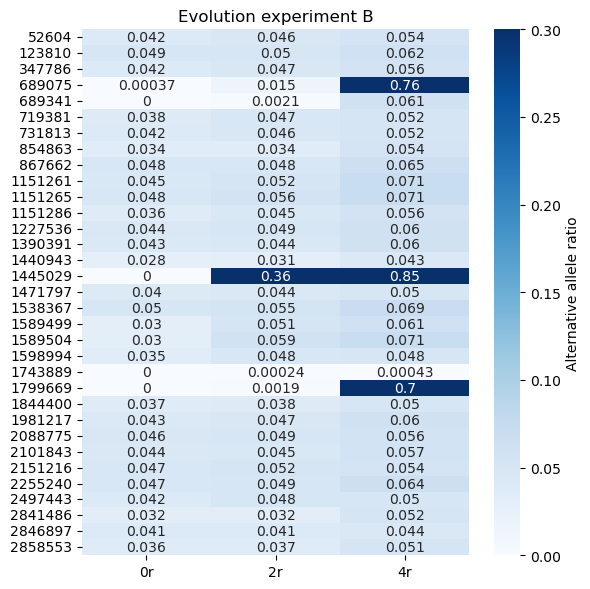

In [7]:
plt.figure(figsize = (6,6))
sns.heatmap(evoB_sig[[col for col in evoB_sig.columns if col.endswith('_ratio')]],
             yticklabels=evoB_sig['POS'],       
             xticklabels=['0r','2r','4r'],  
            cmap="Blues",
            vmax=0.3,
            annot=True,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment B")
plt.tight_layout()
plt.savefig("evoB_024r_corr_sig.pdf")

### Evolution experiment C, 05/06/2025
### EvoC replicateA: 9,12,15,18=1r,2r,3r,4r

In [31]:
# list the samples you care about
samples = ['1','9','12','15','18']

# build the list of columns you want
meta_cols = ['POS','REF','ALT','QUAL','Gene_ID']
per_sample_cols = []
for s in samples:
    per_sample_cols += [f"{s}_RO", f"{s}_AO", f"{s}_ratio"]

cols = meta_cols + per_sample_cols

# subset
evoC_A = df[cols].copy()
evoC_A

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,9_RO,9_AO,9_ratio,12_RO,12_AO,12_ratio,15_RO,15_AO,15_ratio,18_RO,18_AO,18_ratio
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2500.0,490.0,0.163880,2433,501,0.170757,2923,473,0.139282,2672.0,470.0,0.149586
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2944.0,200.0,0.063613,2906,218,0.069782,3446,233,0.063332,3163.0,194.0,0.057790
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2955.0,331.0,0.100730,2720,269,0.089997,3388,335,0.089981,2955.0,285.0,0.087963
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2551.0,512.0,0.167156,2393,475,0.165621,2526,566,0.183053,2491.0,538.0,0.177616
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3115.0,194.0,0.058628,2905,144,0.047229,3077,191,0.058446,3078.0,188.0,0.057563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2339.0,124.0,0.050345,2115,103,0.046438,2313,119,0.048931,2185.0,106.0,0.046268
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2222.0,475.0,0.176122,2010,454,0.184253,2130,445,0.172816,2007.0,462.0,0.187120
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2477.0,184.0,0.069147,2281,158,0.064781,2402,170,0.066096,2290.0,170.0,0.069106
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3572.0,158.0,0.042359,3374,140,0.039841,3529,138,0.037633,3377.0,106.0,0.030434


In [32]:
evoC_A[(evoC_A['18_ratio']>=0.2)&(evoC_A['1_ratio']<0.05)]

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,9_RO,9_AO,9_ratio,12_RO,12_AO,12_ratio,15_RO,15_AO,15_ratio,18_RO,18_AO,18_ratio
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.0,4820.0,1.0,0.000207,3244,898,0.216803,2676,1367,0.338115,2767.0,1851.0,0.400823


/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_79834/760999675.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


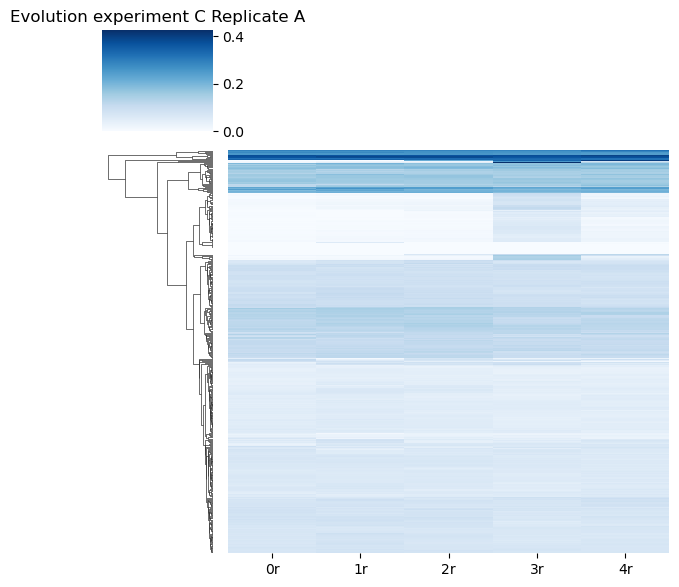

In [141]:
sns.clustermap(evoC_A[[col for col in evoC_A.columns if col.endswith('_ratio')]],
               cmap="Blues",
               col_cluster=False,
               yticklabels=False,  
               xticklabels=['0r','1r','2r','3r','4r'], 
               figsize=(6, 6))
plt.grid(False)
plt.title("Evolution experiment C Replicate A")
plt.tight_layout()
plt.savefig("evoC_A_all.pdf")

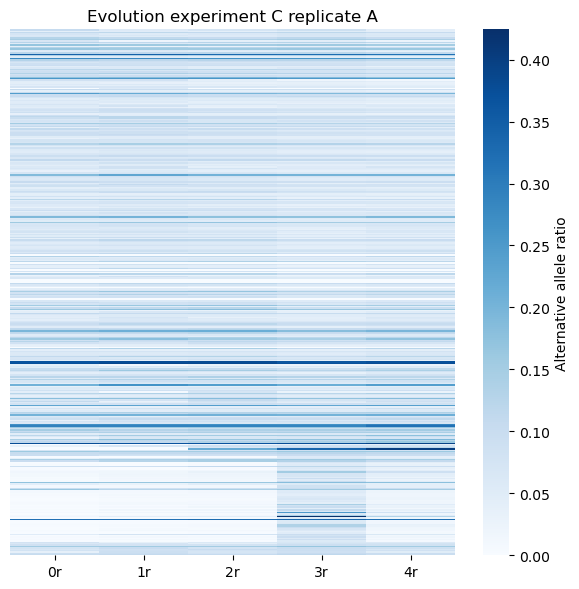

In [105]:
plt.figure(figsize = (6,6))
sns.heatmap(zavit(evoC_A[[col for col in evoC_A.columns if col.endswith('_ratio')]],
                  col_sort=False), 
             yticklabels=False,       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            #vmax=0.4,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment C replicate A")
plt.tight_layout()
plt.savefig("evoC_A_all_zavit.pdf")

In [25]:
filtered_C_A = evoC_A[(evoC_A['18_ratio'] >= evoC_A['15_ratio']) &
                      (evoC_A['15_ratio'] >= evoC_A['12_ratio']) &
                      (evoC_A['12_ratio'] >= evoC_A['9_ratio']) &
                      (evoC_A['9_ratio'] >= evoC_A['1_ratio']) &
                      (evoC_A['18_AO'] >=5) &
                      (evoC_A['18_ratio'] > 0)]
filtered_C_A

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,9_RO,9_AO,9_ratio,12_RO,12_AO,12_ratio,15_RO,15_AO,15_ratio,18_RO,18_AO,18_ratio
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,SAUSA300_RS03310,3169.0,0.0,0.000000,4871.0,0.0,0.000000,4067,285,0.065487,3790,448,0.105710,4156.0,568.0,0.120237
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,4820.0,1.0,0.000207,3244,898,0.216803,2676,1367,0.338115,2767.0,1851.0,0.400823
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,4357.0,2.0,0.000459,3853,96,0.024310,3707,143,0.037143,4001.0,164.0,0.039376
275,1828034,C,A,8.794670e-13,SAUSA300_RS09070,2806.0,0.0,0.000000,4214.0,0.0,0.000000,3866,0,0.000000,3646,0,0.000000,3487.0,12.0,0.003430
312,1995031,T,A,7.591190e-12,No Match,1008.0,47.0,0.044550,1489.0,76.0,0.048562,1503,79,0.049937,2111,112,0.050382,1843.0,107.0,0.054872
330,2016007,A,C,0.000000e+00,SAUSA300_RS10120,1331.0,203.0,0.132334,2121.0,339.0,0.137805,1966,322,0.140734,2472,411,0.142560,2051.0,343.0,0.143275


In [26]:
df_print = filtered_C_A

# the timepoints you want on the x‑axis
samples    = [1, 9, 12, 15, 18]
ro_cols    = [f"{s}_RO"    for s in samples]
ao_cols    = [f"{s}_AO"    for s in samples]
ratio_cols = [f"{s}_ratio" for s in samples]

with PdfPages('evoC_A_filtered_stacked_bar_plots.pdf') as pdf:
    # iterate df_print instead of df
    for _, row in df_print.iterrows():
        fig, ax = plt.subplots()
        x     = list(range(len(samples)))
        ro    = [row[c] for c in ro_cols]
        ao    = [row[c] for c in ao_cols]
        freq  = [row[c] for c in ratio_cols]
        total = [r + a for r, a in zip(ro, ao)]
        y_off = max(total) * 0.02

        bars_ro = ax.bar(x, ro, color="#9ABDDC")
        bars_ao = ax.bar(x, ao, bottom=ro, color="#FFBE65")

        # counts inside segments
        for i, (r, a) in enumerate(zip(ro, ao)):
            if r>0:
                ax.text(i, r/2,    f"{int(r)}", ha='center', va='center',
                        color="#2F76B5", fontsize=9)
            if a>0:
                ax.text(i, r + a/2, f"{int(a)}", ha='center', va='center',
                        color="#A4791D", fontsize=9)

        # frequency above stack
        for i, (tot, f) in enumerate(zip(total, freq)):
            ax.text(i, tot + y_off, f"{f:.5f}", ha='center', va='bottom')

        # expand y‑axis so nothing is clipped
        ax.set_ylim(0, max(total) * 1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(['0r','1r','2r','3r','4r'])
        ax.set_xlabel('Evolution C replicate A time point')
        ax.set_ylabel('Read count')
        ax.set_title(f"{row['Gene_ID']} {row['POS']} {row['REF']} → {row['ALT']}")

        # legend outside
        ax.legend((bars_ro[0], bars_ao[0]), ('RO','AO'),
                  loc='upper left', bbox_to_anchor=(1.02,1),
                  frameon=False)
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

In [34]:
evoC_A = add_spearman_corr_to_df(evoC_A, pattern=[1, 2, 3, 4, 5])
evoC_A

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,9_RO,9_AO,...,12_AO,12_ratio,15_RO,15_AO,15_ratio,18_RO,18_AO,18_ratio,spearman_r,spearman_p
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2500.0,490.0,...,501,0.170757,2923,473,0.139282,2672.0,470.0,0.149586,-0.5,0.391002
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2944.0,200.0,...,218,0.069782,3446,233,0.063332,3163.0,194.0,0.057790,-0.7,0.18812
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2955.0,331.0,...,269,0.089997,3388,335,0.089981,2955.0,285.0,0.087963,-1.0,0.0
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2551.0,512.0,...,475,0.165621,2526,566,0.183053,2491.0,538.0,0.177616,0.5,0.391002
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,3115.0,194.0,...,144,0.047229,3077,191,0.058446,3078.0,188.0,0.057563,-0.7,0.18812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2339.0,124.0,...,103,0.046438,2313,119,0.048931,2185.0,106.0,0.046268,0.1,0.872889
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2222.0,475.0,...,454,0.184253,2130,445,0.172816,2007.0,462.0,0.187120,0.3,0.623838
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2477.0,184.0,...,158,0.064781,2402,170,0.066096,2290.0,170.0,0.069106,-0.6,0.284757
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3572.0,158.0,...,140,0.039841,3529,138,0.037633,3377.0,106.0,0.030434,-0.4,0.504632


In [57]:
evoC_A_sig = evoC_A[(evoC_A['spearman_p']<0.05)&(evoC_A['spearman_r']>0)&(evoC_A['1_ratio']<0.05)]
evoC_A_sig

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,9_RO,9_AO,...,12_AO,12_ratio,15_RO,15_AO,15_ratio,18_RO,18_AO,18_ratio,spearman_r,spearman_p
20,93040,C,T,1.411780e-12,No Match,2682.0,23.0,0.008503,4216.0,39.0,...,47,0.012414,3111,176,0.053544,3103.0,78.0,0.024521,0.9,0.037386
21,93045,A,G,8.833240e-13,No Match,2691.0,24.0,0.008840,4173.0,40.0,...,50,0.013390,3102,182,0.055420,3078.0,78.0,0.024715,0.9,0.037386
31,217176,A,C,0.000000e+00,brnQ,2829.0,3.0,0.001059,3964.0,17.0,...,20,0.005051,4018,219,0.051688,4069.0,75.0,0.018098,0.9,0.037386
39,273576,A,C,3.811020e-12,SAUSA300_RS01205,1662.0,83.0,0.047564,2533.0,144.0,...,151,0.059030,2478,164,0.062074,2460.0,159.0,0.060710,0.9,0.037386
48,314481,A,G,0.000000e+00,No Match,3406.0,2.0,0.000587,5181.0,8.0,...,8,0.001664,4512,231,0.048703,4757.0,49.0,0.010196,0.9,0.037386
51,343766,G,A,1.882370e-12,SAUSA300_RS01540,3094.0,5.0,0.001613,4730.0,14.0,...,29,0.006822,3590,330,0.084184,3662.0,101.0,0.026840,0.9,0.037386
86,488543,T,C,0.000000e+00,No Match,3004.0,7.0,0.002325,4751.0,37.0,...,43,0.009064,5616,877,0.135069,5198.0,163.0,0.030405,0.9,0.037386
111,607259,G,C,4.073320e-12,No Match,2774.0,4.0,0.001440,4273.0,15.0,...,25,0.006324,4066,284,0.065287,3849.0,76.0,0.019363,0.9,0.037386
113,623678,A,C,1.188050e-12,SAUSA300_RS02930,3152.0,3.0,0.000951,4888.0,21.0,...,21,0.004479,5533,397,0.066948,4821.0,118.0,0.023891,0.9,0.037386
114,624666,AAC,GAT,0.000000e+00,SAUSA300_RS02935,2511.0,20.0,0.007902,4026.0,34.0,...,49,0.012912,4023,434,0.097375,3612.0,177.0,0.046714,0.9,0.037386


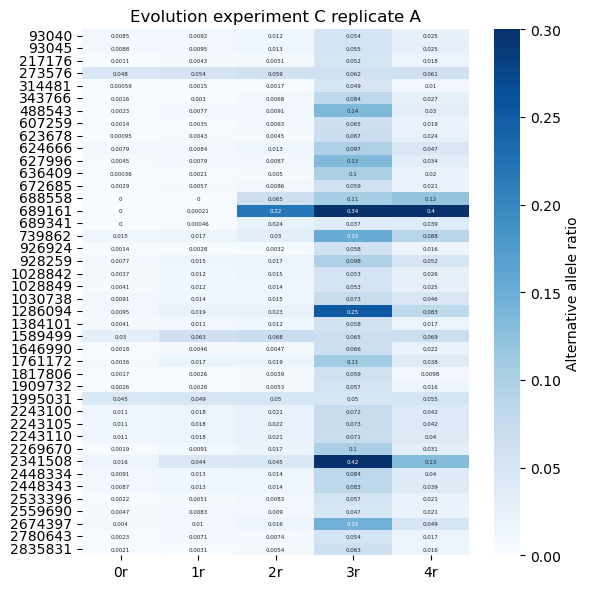

In [77]:
plt.figure(figsize = (6,6))
sns.heatmap(evoC_A_sig[[col for col in evoC_A_sig.columns if col.endswith('_ratio')]],
             yticklabels=evoC_A_sig['POS'],       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            vmax=0.3,
            annot=True,annot_kws={"size":4},
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment C replicate A")
plt.tight_layout()
plt.savefig("evoC_A_corr_sig.pdf")

### EvoC replicateB: 10,13,16,19=1r,2r,3r,4r

In [10]:
# list the samples you care about
samples = ['1','10','13','16','19']

# build the list of columns you want
meta_cols = ['POS','REF','ALT','QUAL','Gene_ID']
per_sample_cols = []
for s in samples:
    per_sample_cols += [f"{s}_RO", f"{s}_AO", f"{s}_ratio"]

cols = meta_cols + per_sample_cols

# subset
evoC_B = df[cols].copy()
evoC_B

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,10_RO,10_AO,10_ratio,13_RO,13_AO,13_ratio,16_RO,16_AO,16_ratio,19_RO,19_AO,19_ratio
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2043.0,361.0,0.150166,2935,519,0.150261,2505.0,458.0,0.154573,2959.0,498.0,0.144056
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2451.0,169.0,0.064504,3486,260,0.069407,2981.0,196.0,0.061693,3502.0,226.0,0.060622
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2323.0,275.0,0.105851,3373,353,0.094740,2936.0,314.0,0.096615,3295.0,350.0,0.096022
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2002.0,450.0,0.183524,2636,576,0.179328,2220.0,501.0,0.184123,2396.0,549.0,0.186418
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,2430.0,152.0,0.058869,3254,203,0.058721,2771.0,184.0,0.062267,3018.0,185.0,0.057758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,1980.0,101.0,0.048534,2144,118,0.052166,2137.0,116.0,0.051487,2213.0,120.0,0.051436
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,1844.0,440.0,0.192644,1971,468,0.191882,1984.0,472.0,0.192182,2046.0,492.0,0.193853
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2084.0,168.0,0.074600,2211,168,0.070618,2260.0,183.0,0.074908,2306.0,192.0,0.076861
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,2866.0,107.0,0.035991,3263,141,0.041422,3175.0,137.0,0.041365,3377.0,136.0,0.038713


In [13]:
evoC_B[(evoC_B['19_ratio']>=0.2)&(evoC_B['1_ratio']<0.05)]

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,10_RO,10_AO,10_ratio,13_RO,13_AO,13_ratio,16_RO,16_AO,16_ratio,19_RO,19_AO,19_ratio
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,3816.0,9.0,0.002353,3355,1098,0.246575,2642.0,1378.0,0.342786,2483.0,1449.0,0.368515
194,1286094,C,T,9.566130e-12,No Match,2810.0,27.0,0.009517,3756.0,12.0,0.003185,3620,1079,0.229623,4172.0,1322.0,0.240626,3156.0,861.0,0.214339
381,2341508,T,A,0.000000e+00,No Match,2958.0,48.0,0.015968,3758.0,33.0,0.008705,4335,2363,0.352792,4155.0,3137.0,0.430197,4276.0,1621.0,0.274886


/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_79834/3073475362.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


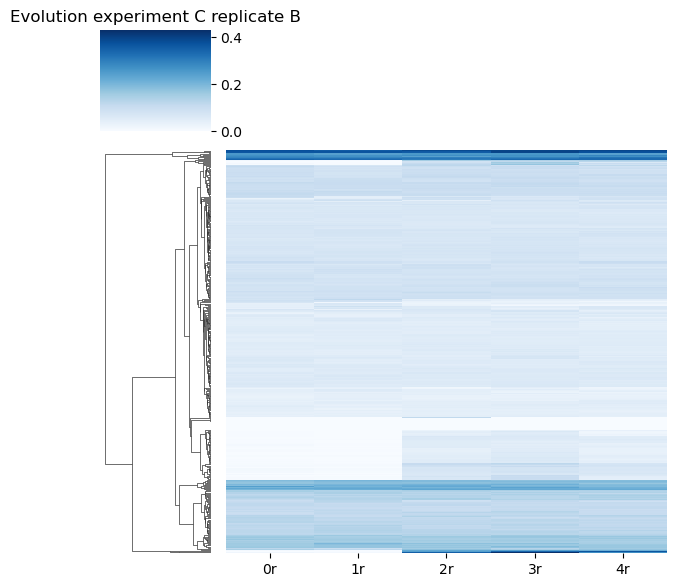

In [123]:
sns.clustermap(evoC_B[[col for col in evoC_B.columns if col.endswith('_ratio')]],
               cmap="Blues",
               col_cluster=False,
               yticklabels=False,  
               xticklabels=['0r','1r','2r','3r','4r'], 
               figsize=(6, 6))
plt.grid(False)
plt.title("Evolution experiment C replicate B")
plt.tight_layout()
plt.savefig("evoC_B_all.pdf")

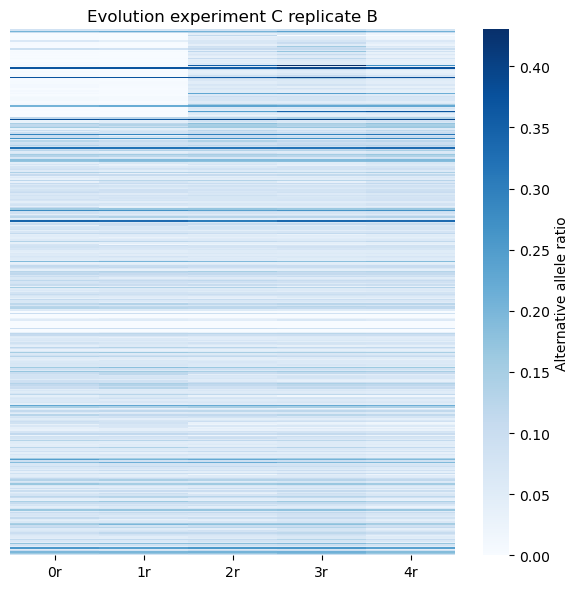

In [104]:
plt.figure(figsize = (6,6))
sns.heatmap(zavit(evoC_B[[col for col in evoC_B.columns if col.endswith('_ratio')]],
                  col_sort=False), 
             yticklabels=False,       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            #vmax=0.4,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment C replicate B")
plt.tight_layout()
plt.savefig("evoC_B_all_zavit.pdf")

In [28]:
filtered_C_B = evoC_B[(evoC_B['19_ratio'] >= evoC_B['16_ratio']) &
                      (evoC_B['16_ratio'] >= evoC_B['13_ratio']) &
                      (evoC_B['13_ratio'] >= evoC_B['10_ratio']) &
                      (evoC_B['10_ratio'] >= evoC_B['1_ratio']) &
                      (evoC_B['19_AO'] >= 5) &
                      (evoC_B['19_ratio'] > 0)]
filtered_C_B

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,10_RO,10_AO,10_ratio,13_RO,13_AO,13_ratio,16_RO,16_AO,16_ratio,19_RO,19_AO,19_ratio
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,SAUSA300_RS03310,3169.0,0.0,0.000000,3899.0,0.0,0.000000,3919,355,0.083060,3743.0,484.0,0.114502,3462.0,491.0,0.124209
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,3816.0,9.0,0.002353,3355,1098,0.246575,2642.0,1378.0,0.342786,2483.0,1449.0,0.368515
135,731828,T,G,7.328890e-12,SAUSA300_RS03510,2078.0,125.0,0.056741,2597.0,158.0,0.057350,2213,144,0.061095,2721.0,179.0,0.061724,2143.0,153.0,0.066638
247,1589499,GACTG,AACCC,0.000000e+00,SAUSA300_RS07840,1112.0,34.0,0.029668,1487.0,70.0,0.044958,1245,77,0.058245,1498.0,93.0,0.058454,1262.0,93.0,0.068635
312,1995031,T,A,7.591190e-12,No Match,1008.0,47.0,0.044550,1191.0,63.0,0.050239,2298,122,0.050413,1976.0,107.0,0.051368,2127.0,122.0,0.054246


In [30]:
df_print = filtered_C_B

# the timepoints you want on the x‑axis
samples    = [1, 10, 13, 16, 19]
ro_cols    = [f"{s}_RO"    for s in samples]
ao_cols    = [f"{s}_AO"    for s in samples]
ratio_cols = [f"{s}_ratio" for s in samples]

with PdfPages('evoC_B_filtered_stacked_bar_plots.pdf') as pdf:
    # iterate df_print instead of df
    for _, row in df_print.iterrows():
        fig, ax = plt.subplots()
        x     = list(range(len(samples)))
        ro    = [row[c] for c in ro_cols]
        ao    = [row[c] for c in ao_cols]
        freq  = [row[c] for c in ratio_cols]
        total = [r + a for r, a in zip(ro, ao)]
        y_off = max(total) * 0.02

        bars_ro = ax.bar(x, ro, color="#9ABDDC")
        bars_ao = ax.bar(x, ao, bottom=ro, color="#FFBE65")

        # counts inside segments
        for i, (r, a) in enumerate(zip(ro, ao)):
            if r>0:
                ax.text(i, r/2,    f"{int(r)}", ha='center', va='center',
                        color="#2F76B5", fontsize=9)
            if a>0:
                ax.text(i, r + a/2, f"{int(a)}", ha='center', va='center',
                        color="#A4791D", fontsize=9)

        # frequency above stack
        for i, (tot, f) in enumerate(zip(total, freq)):
            ax.text(i, tot + y_off, f"{f:.5f}", ha='center', va='bottom')

        # expand y‑axis so nothing is clipped
        ax.set_ylim(0, max(total) * 1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(['0r','1r','2r','3r','4r'])
        ax.set_xlabel('Evolution C replicate B time point')
        ax.set_ylabel('Read count')
        ax.set_title(f"{row['Gene_ID']} {row['POS']} {row['REF']} → {row['ALT']}")

        # legend outside
        ax.legend((bars_ro[0], bars_ao[0]), ('RO','AO'),
                  loc='upper left', bbox_to_anchor=(1.02,1),
                  frameon=False)
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

In [53]:
evoC_B = add_spearman_corr_to_df(evoC_B, pattern=[1, 2, 3, 4, 5])
evoC_B_sig = evoC_B[(evoC_B['spearman_p']<0.05)&(evoC_B['spearman_r']>0)&(evoC_B['1_ratio']<0.05)]
evoC_B_sig

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,10_RO,10_AO,...,13_AO,13_ratio,16_RO,16_AO,16_ratio,19_RO,19_AO,19_ratio,spearman_r,spearman_p
11,61745,GC,AT,0.000000e+00,No Match,2630.0,4.0,0.001519,3214.0,2.0,...,258,0.064163,4115.0,297.0,0.067316,3551.0,271.0,0.070905,0.9,0.037386
83,474432,G,A,0.000000e+00,SAUSA300_RS02265,2250.0,80.0,0.034335,2597.0,132.0,...,205,0.057536,2965.0,170.0,0.054226,3660.0,230.0,0.059126,0.9,0.037386
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,SAUSA300_RS03310,3169.0,0.0,0.000000,3899.0,0.0,...,355,0.083060,3743.0,484.0,0.114502,3462.0,491.0,0.124209,0.974679,0.004818
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,3816.0,9.0,...,1098,0.246575,2642.0,1378.0,0.342786,2483.0,1449.0,0.368515,1.0,0.0
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,3461.0,1.0,...,113,0.027615,3566.0,140.0,0.037777,3460.0,132.0,0.036748,0.9,0.037386
131,719381,ACAG,CCAA,9.180400e-12,graR,1515.0,60.0,0.038095,1814.0,79.0,...,77,0.040849,1877.0,82.0,0.041858,1686.0,78.0,0.044218,0.9,0.037386
177,1151261,T,G,5.122510e-12,No Match,2031.0,95.0,0.044685,2553.0,126.0,...,116,0.051169,2663.0,137.0,0.048929,2149.0,121.0,0.053304,0.9,0.037386
179,1151286,T,G,0.000000e+00,No Match,1818.0,67.0,0.035544,2302.0,98.0,...,88,0.044625,2368.0,114.0,0.045931,1890.0,89.0,0.044972,0.9,0.037386
247,1589499,GACTG,AACCC,0.000000e+00,SAUSA300_RS07840,1112.0,34.0,0.029668,1487.0,70.0,...,77,0.058245,1498.0,93.0,0.058454,1262.0,93.0,0.068635,1.0,0.0
254,1598994,C,A,0.000000e+00,scpB,1955.0,70.0,0.034568,2564.0,129.0,...,104,0.045415,2524.0,129.0,0.048624,2052.0,114.0,0.052632,0.9,0.037386


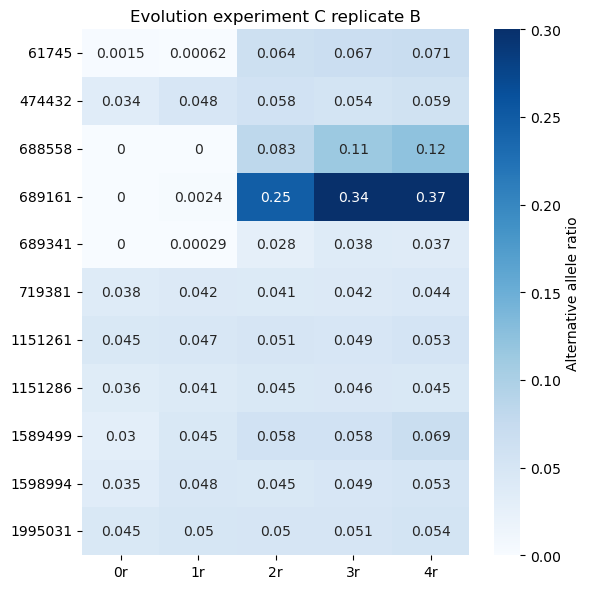

In [74]:
plt.figure(figsize = (6,6))
sns.heatmap(evoC_B_sig[[col for col in evoC_B_sig.columns if col.endswith('_ratio')]],
             yticklabels=evoC_B_sig['POS'],       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            vmax=0.3,
            annot=True,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment C replicate B")
plt.tight_layout()
plt.savefig("evoC_B_corr_sig.pdf")

### EvoC replicateC: 11,14,17,20=1r,2r,3r,4r

In [8]:
# list the samples you care about
samples = ['1','11','14','17','20']

# build the list of columns you want
meta_cols = ['POS','REF','ALT','QUAL','Gene_ID']
per_sample_cols = []
for s in samples:
    per_sample_cols += [f"{s}_RO", f"{s}_AO", f"{s}_ratio"]

cols = meta_cols + per_sample_cols

# subset
evoC_C = df[cols].copy()
evoC_C

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,11_RO,11_AO,11_ratio,14_RO,14_AO,14_ratio,17_RO,17_AO,17_ratio,20_RO,20_AO,20_ratio
2,12743,A,C,0.000000e+00,SAUSA300_RS14805,1756.0,319.0,0.153735,2367.0,472.0,0.166256,2051,399,0.162857,2366.0,410.0,0.147695,2244,441,0.164246
3,12750,A,C,7.251740e-12,SAUSA300_RS14805,2124.0,146.0,0.064317,2805.0,243.0,0.079724,2444,179,0.068242,2817.0,180.0,0.060060,2681,220,0.075836
4,13778,A,C,0.000000e+00,"serS, SAUSA300_RS14805",1945.0,238.0,0.109024,2794.0,305.0,0.098419,2450,250,0.092593,2682.0,256.0,0.087134,2655,310,0.104553
5,33404,A,C,2.079860e-11,No Match,1626.0,340.0,0.172940,2416.0,499.0,0.171184,1934,450,0.188758,2038.0,451.0,0.181197,2196,512,0.189069
6,33414,G,A,3.641300e-12,No Match,1996.0,131.0,0.061589,2935.0,195.0,0.062300,2393,122,0.048509,2533.0,135.0,0.050600,2700,149,0.052299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2277.0,109.0,0.045683,1850,100,0.051282,1919.0,110.0,0.054214,2123,137,0.060619
461,2846904,A,C,1.172620e-11,No Match,1545.0,342.0,0.181240,2188.0,466.0,0.175584,1749,387,0.181180,1737.0,420.0,0.194715,1933,458,0.191552
462,2846907,T,C,0.000000e+00,No Match,1752.0,133.0,0.070557,2408.0,186.0,0.071704,1974,159,0.074543,1999.0,161.0,0.074537,2208,162,0.068354
463,2858553,A,C,0.000000e+00,No Match,2455.0,91.0,0.035742,3378.0,163.0,0.046032,2733,132,0.046073,2942.0,82.0,0.027116,3147,135,0.041133


In [9]:
evoC_C[evoC_C['20_ratio']>=0.2]

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,11_RO,11_AO,11_ratio,14_RO,14_AO,14_ratio,17_RO,17_AO,17_ratio,20_RO,20_AO,20_ratio
24,110748,GGCTA,AGCTC,3.092020e-11,SAUSA300_RS00520,2424.0,1144.0,0.320628,3597.0,1716.0,0.322981,2818,1287,0.313520,2653.0,1345.0,0.336418,3338,1495,0.309332
103,556610,C,T,0.000000e+00,"SAUSA300_RS02675, SAUSA300_RS02675",525.0,318.0,0.377224,770.0,436.0,0.361526,833,514,0.381589,886.0,599.0,0.403367,734,424,0.366149
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,4505.0,3.0,0.000665,3482,127,0.035190,2723.0,1087.0,0.285302,2513,1510,0.375342
264,1724800,T,G,0.000000e+00,No Match,1457.0,357.0,0.196803,2289.0,654.0,0.222222,1679,463,0.216153,1860.0,414.0,0.182058,2291,585,0.203408
267,1755980,A,G,1.536750e-11,SAUSA300_RS08725,1483.0,481.0,0.244908,2342.0,564.0,0.194081,2317,328,0.124008,1926.0,453.0,0.190416,2195,618,0.219694
286,1857109,A,G,5.492810e-11,SAUSA300_RS09205,2251.0,824.0,0.267967,3818.0,1370.0,0.264071,2859,1052,0.268985,2837.0,980.0,0.256746,3584,1245,0.257817
287,1857117,T,C,2.135410e-11,SAUSA300_RS09205,2122.0,875.0,0.291959,3561.0,1456.0,0.290213,2722,1126,0.292620,2650.0,1026.0,0.279108,3337,1307,0.281438
313,1996876,ATAATTAC,AAATGGAATTTAAGA,2.727890e-11,No Match,2476.0,1468.0,0.372211,3118.0,2048.0,0.396438,4150,2483,0.374340,4506.0,2800.0,0.383247,3576,2115,0.371639
314,1996887,ATA,AA,0.000000e+00,No Match,2615.0,1515.0,0.366828,3306.0,2118.0,0.390487,4360,2593,0.372933,4765.0,2915.0,0.379557,3749,2163,0.365866
324,1997580,TAAAAC,TGTCATT,0.000000e+00,No Match,2726.0,1428.0,0.343765,3750.0,1868.0,0.332503,4588,2289,0.332849,5131.0,2567.0,0.333463,3912,1933,0.330710


/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_79834/2409026159.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


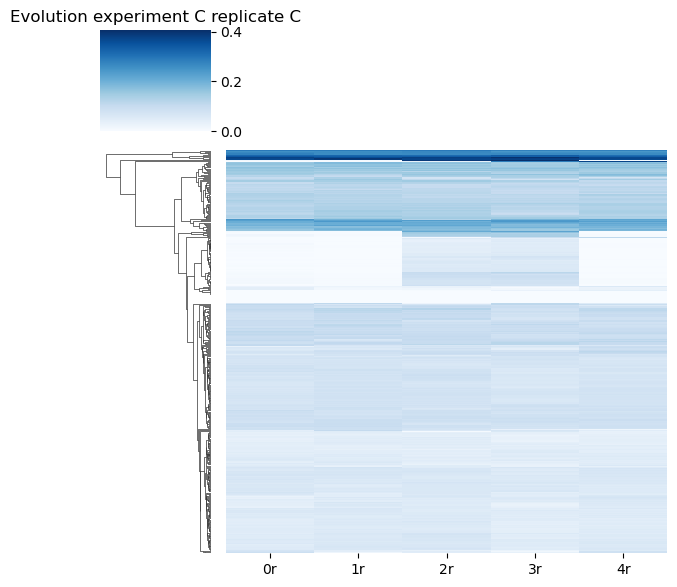

In [122]:
sns.clustermap(evoC_C[[col for col in evoC_C.columns if col.endswith('_ratio')]],
               cmap="Blues",
               col_cluster=False,
               yticklabels=False,  
               xticklabels=['0r','1r','2r','3r','4r'], 
               figsize=(6, 6))
plt.grid(False)
plt.title("Evolution experiment C replicate C")
plt.tight_layout()
plt.savefig("evoC_C_all.pdf")

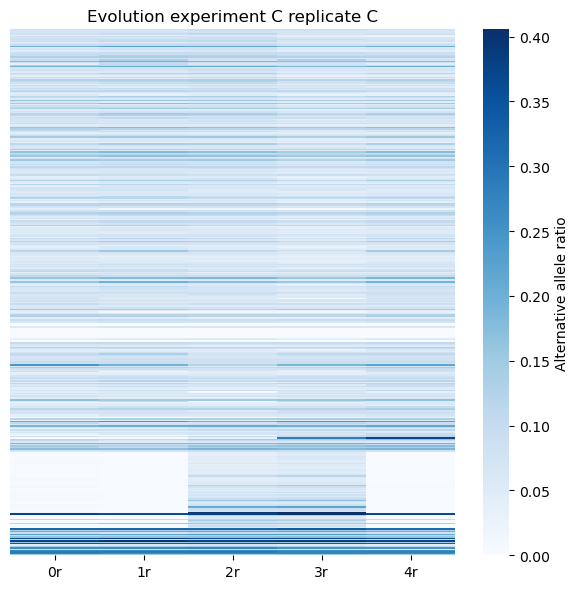

In [103]:
plt.figure(figsize = (6,6))
sns.heatmap(zavit(evoC_C[[col for col in evoC_C.columns if col.endswith('_ratio')]],
                  col_sort=False), 
             yticklabels=False,       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            #vmax=0.4,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment C replicate C")
plt.tight_layout()
plt.savefig("evoC_C_all_zavit.pdf")

In [32]:
filtered_C_C = evoC_C[(evoC_C['20_ratio'] >= evoC_C['17_ratio']) &
                      (evoC_C['17_ratio'] >= evoC_C['14_ratio']) &
                      (evoC_C['14_ratio'] >= evoC_C['11_ratio']) &
                      (evoC_C['11_ratio'] >= evoC_C['1_ratio']) &
                      (evoC_C['20_AO'] >= 5) &
                      (evoC_C['20_ratio'] > 0)]
filtered_C_C

,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,11_RO,11_AO,11_ratio,14_RO,14_AO,14_ratio,17_RO,17_AO,17_ratio,20_RO,20_AO,20_ratio
83,474432,G,A,0.000000e+00,SAUSA300_RS02265,2250.0,80.0,0.034335,3083.0,157.0,0.048457,2516,131,0.049490,2597.0,165.0,0.059739,2784,200,0.067024
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,SAUSA300_RS03310,3169.0,0.0,0.000000,4644.0,1.0,0.000215,3656,35,0.009483,3501.0,355.0,0.092064,3702,460,0.110524
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,4505.0,3.0,0.000665,3482,127,0.035190,2723.0,1087.0,0.285302,2513,1510,0.375342
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,4214.0,0.0,0.000000,3355,14,0.004156,3306.0,92.0,0.027075,3811,153,0.038597
173,1034085,T,C,0.000000e+00,SAUSA300_RS05080,2085.0,175.0,0.077434,2891.0,258.0,0.081931,2303,237,0.093307,2459.0,257.0,0.094624,2671,323,0.107882
312,1995031,T,A,7.591190e-12,No Match,1008.0,47.0,0.044550,1376.0,65.0,0.045108,1603,80,0.047534,1778.0,93.0,0.049706,1335,83,0.058533
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2277.0,109.0,0.045683,1850,100,0.051282,1919.0,110.0,0.054214,2123,137,0.060619


In [33]:
df_print = filtered_C_C

# the timepoints you want on the x‑axis
samples    = [1, 11, 14, 17, 20]
ro_cols    = [f"{s}_RO"    for s in samples]
ao_cols    = [f"{s}_AO"    for s in samples]
ratio_cols = [f"{s}_ratio" for s in samples]

with PdfPages('evoC_C_filtered_stacked_bar_plots.pdf') as pdf:
    # iterate df_print instead of df
    for _, row in df_print.iterrows():
        fig, ax = plt.subplots()
        x     = list(range(len(samples)))
        ro    = [row[c] for c in ro_cols]
        ao    = [row[c] for c in ao_cols]
        freq  = [row[c] for c in ratio_cols]
        total = [r + a for r, a in zip(ro, ao)]
        y_off = max(total) * 0.02

        bars_ro = ax.bar(x, ro, color="#9ABDDC")
        bars_ao = ax.bar(x, ao, bottom=ro, color="#FFBE65")

        # counts inside segments
        for i, (r, a) in enumerate(zip(ro, ao)):
            if r>0:
                ax.text(i, r/2,    f"{int(r)}", ha='center', va='center',
                        color="#2F76B5", fontsize=9)
            if a>0:
                ax.text(i, r + a/2, f"{int(a)}", ha='center', va='center',
                        color="#A4791D", fontsize=9)

        # frequency above stack
        for i, (tot, f) in enumerate(zip(total, freq)):
            ax.text(i, tot + y_off, f"{f:.5f}", ha='center', va='bottom')

        # expand y‑axis so nothing is clipped
        ax.set_ylim(0, max(total) * 1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(['0r','1r','2r','3r','4r'])
        ax.set_xlabel('Evolution C replicate C time point')
        ax.set_ylabel('Read count')
        ax.set_title(f"{row['Gene_ID']} {row['POS']} {row['REF']} → {row['ALT']}")

        # legend outside
        ax.legend((bars_ro[0], bars_ao[0]), ('RO','AO'),
                  loc='upper left', bbox_to_anchor=(1.02,1),
                  frameon=False)
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

In [55]:
evoC_C = add_spearman_corr_to_df(evoC_C, pattern=[1, 2, 3, 4, 5])
evoC_C_sig = evoC_C[(evoC_C['spearman_p']<0.05)&(evoC_C['spearman_r']>0)&(evoC_C['1_ratio']<0.05)]
evoC_C_sig

/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/peien/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,POS,REF,ALT,QUAL,Gene_ID,1_RO,1_AO,1_ratio,11_RO,11_AO,...,14_AO,14_ratio,17_RO,17_AO,17_ratio,20_RO,20_AO,20_ratio,spearman_r,spearman_p
9,52604,A,G,2.530400e-12,No Match,530.0,23.0,0.041591,787.0,36.0,...,25,0.041946,565.0,28.0,0.047218,744,41,0.052229,0.9,0.037386
39,273576,A,C,3.811020e-12,SAUSA300_RS01205,1662.0,83.0,0.047564,2388.0,143.0,...,110,0.052506,2082.0,125.0,0.056638,2210,147,0.062367,0.9,0.037386
83,474432,G,A,0.000000e+00,SAUSA300_RS02265,2250.0,80.0,0.034335,3083.0,157.0,...,131,0.049490,2597.0,165.0,0.059739,2784,200,0.067024,1.0,0.0
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,SAUSA300_RS03310,3169.0,0.0,0.000000,4644.0,1.0,...,35,0.009483,3501.0,355.0,0.092064,3702,460,0.110524,1.0,0.0
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,SAUSA300_RS03310,3184.0,0.0,0.000000,4505.0,3.0,...,127,0.035190,2723.0,1087.0,0.285302,2513,1510,0.375342,1.0,0.0
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,SAUSA300_RS03310,2794.0,0.0,0.000000,4214.0,0.0,...,14,0.004156,3306.0,92.0,0.027075,3811,153,0.038597,0.974679,0.004818
247,1589499,GACTG,AACCC,0.000000e+00,SAUSA300_RS07840,1112.0,34.0,0.029668,1815.0,84.0,...,93,0.065217,1376.0,67.0,0.046431,1665,121,0.067749,0.9,0.037386
248,1589504,TT,CC,0.000000e+00,SAUSA300_RS07840,1469.0,46.0,0.030363,2117.0,133.0,...,130,0.076832,1636.0,117.0,0.066743,1965,203,0.093635,0.9,0.037386
312,1995031,T,A,7.591190e-12,No Match,1008.0,47.0,0.044550,1376.0,65.0,...,80,0.047534,1778.0,93.0,0.049706,1335,83,0.058533,1.0,0.0
460,2846897,A,C,0.000000e+00,No Match,1633.0,70.0,0.041104,2277.0,109.0,...,100,0.051282,1919.0,110.0,0.054214,2123,137,0.060619,1.0,0.0


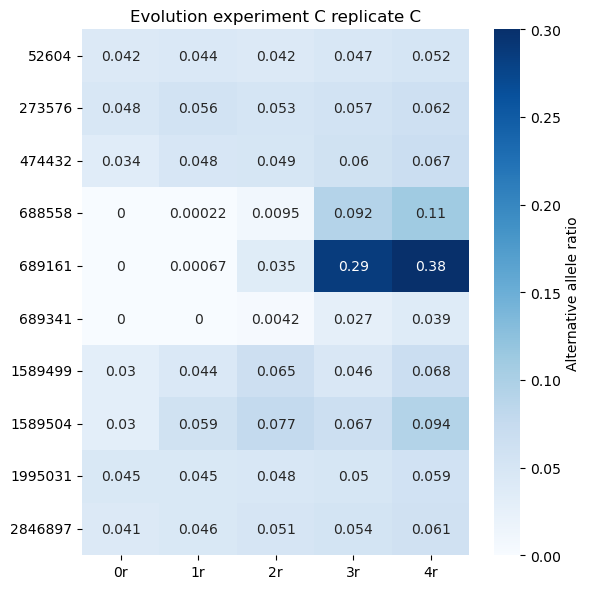

In [75]:
plt.figure(figsize = (6,6))
sns.heatmap(evoC_C_sig[[col for col in evoC_C_sig.columns if col.endswith('_ratio')]],
             yticklabels=evoC_C_sig['POS'],       
             xticklabels=['0r','1r','2r','3r','4r'],  
            cmap="Blues",
            vmax=0.3,
            annot=True,
            cbar_kws={'label': 'Alternative allele ratio'})
plt.grid(False)
plt.title("Evolution experiment C replicate C")
plt.tight_layout()
plt.savefig("evoC_C_corr_sig.pdf")

In [38]:
filtered_A.to_csv("evoA_filtered.csv")
filtered_B.to_csv("evoB_filtered.csv")
filtered_C_A.to_csv("evoC_A_filtered.csv")
filtered_C_B.to_csv("evoC_B_filtered.csv")      
filtered_C_C.to_csv("evoC_C_filtered.csv")

### Look at dominant mutations

In [70]:
df_print = evoB[evoB['7_ratio']>0.4]

# the timepoints you want on the x‑axis
samples    = [1, 6, 7, 8]
ro_cols    = [f"{s}_RO"    for s in samples]
ao_cols    = [f"{s}_AO"    for s in samples]
ratio_cols = [f"{s}_ratio" for s in samples]

with PdfPages('evoB_dominant_filtered_stacked_bar_plots.pdf') as pdf:
    # iterate df_print instead of df
    for _, row in df_print.iterrows():
        fig, ax = plt.subplots()
        x     = list(range(len(samples)))
        ro    = [row[c] for c in ro_cols]
        ao    = [row[c] for c in ao_cols]
        freq  = [row[c] for c in ratio_cols]
        total = [r + a for r, a in zip(ro, ao)]
        y_off = max(total) * 0.02

        bars_ro = ax.bar(x, ro, color="#9ABDDC")
        bars_ao = ax.bar(x, ao, bottom=ro, color="#FFBE65")

        # counts inside segments
        for i, (r, a) in enumerate(zip(ro, ao)):
            if r>0:
                ax.text(i, r/2,    f"{int(r)}", ha='center', va='center',
                        color="#2F76B5", fontsize=9)
            if a>0:
                ax.text(i, r + a/2, f"{int(a)}", ha='center', va='center',
                        color="#A4791D", fontsize=9)

        # frequency above stack
        for i, (tot, f) in enumerate(zip(total, freq)):
            ax.text(i, tot + y_off, f"{f:.5f}", ha='center', va='bottom')

        # expand y‑axis so nothing is clipped
        ax.set_ylim(0, max(total) * 1.2)

        ax.set_xticks(x)
        ax.set_xticklabels(['0r','2r','4r','Holiday'])
        ax.set_xlabel('Evolution B time point')
        ax.set_ylabel('Read count')
        ax.set_title(f"{row['Gene_ID']} {row['POS']} {row['REF']} → {row['ALT']}")

        # legend outside
        ax.legend((bars_ro[0], bars_ao[0]), ('RO','AO'),
                  loc='upper left', bbox_to_anchor=(1.02,1),
                  frameon=False)
        plt.tight_layout()

        pdf.savefig(fig)
        plt.close(fig)

## All the variants together

In [4]:
df = df[df['1_ratio']<0.05]
df

,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,18_ratio,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio
9,52604,A,G,2.530400e-12,770.0,25.0,738,42,789.0,38.0,...,0.040367,0.041597,0.063830,0.052229,0.034954,0.041946,0.027287,0.033083,0.050590,0.047218
11,61745,GC,AT,0.000000e+00,3841.0,5.0,3880,4,3803.0,2.0,...,0.045607,0.066257,0.046356,0.000291,0.000622,0.059790,0.072642,0.067316,0.070905,0.058145
12,62324,C,T,6.148550e-12,4816.0,4.0,4975,10,4664.0,0.0,...,0.037991,0.056446,0.044624,0.000000,0.001995,0.049698,0.058684,0.056114,0.058837,0.054476
13,68194,A,G,0.000000e+00,4595.0,1.0,4556,4,4268.0,3.0,...,0.034030,0.055689,0.038941,0.000000,0.000521,0.042821,0.052688,0.049201,0.045574,0.049037
14,68310,A,C,0.000000e+00,4218.0,2.0,4266,10,3986.0,8.0,...,0.039609,0.053157,0.039701,0.000811,0.001427,0.048519,0.057525,0.051570,0.055046,0.054533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,2835831,G,T,1.107050e-12,4229.0,13.0,4028,1,3898.0,0.0,...,0.016279,0.011981,0.015012,0.000295,0.001564,0.055789,0.032124,0.064875,0.019511,0.060317
457,2841486,A,C,3.085870e-14,3297.0,100.0,3208,177,3101.0,104.0,...,0.030442,0.036648,0.031921,0.036802,0.039330,0.041291,0.032676,0.032135,0.033468,0.025875
458,2846886,T,G,2.356820e-12,2943.0,155.0,2975,125,2925.0,121.0,...,0.048746,0.036389,0.041174,0.039957,0.040478,0.043302,0.038319,0.042920,0.047345,0.039732
460,2846897,A,C,0.000000e+00,2339.0,124.0,2379,110,2354.0,101.0,...,0.046268,0.052863,0.041985,0.060619,0.048534,0.051282,0.041667,0.051487,0.051436,0.054214


In [11]:
mat = df[[col for col in df.columns if col.endswith('_ratio')]]
mat.index = df['POS']
mat

,9_ratio,7_ratio,6_ratio,4_ratio,1_ratio,13_ratio,12_ratio,11_ratio,5_ratio,15_ratio,18_ratio,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio
POS,,,,,,,,,,,,,,,,,,,,
52604,0.031447,0.053846,0.045949,0.038737,0.041591,0.040067,0.046875,0.043742,0.034003,0.057437,0.040367,0.041597,0.063830,0.052229,0.034954,0.041946,0.027287,0.033083,0.050590,0.047218
61745,0.001300,0.001030,0.000526,0.059736,0.001519,0.064163,0.005792,0.000513,0.031880,0.069377,0.045607,0.066257,0.046356,0.000291,0.000622,0.059790,0.072642,0.067316,0.070905,0.058145
62324,0.000830,0.002006,0.000000,0.044112,0.002122,0.059216,0.005405,0.000212,0.030250,0.060695,0.037991,0.056446,0.044624,0.000000,0.001995,0.049698,0.058684,0.056114,0.058837,0.054476
68194,0.000218,0.000877,0.000702,0.038229,0.003530,0.052939,0.005221,0.000453,0.025136,0.054008,0.034030,0.055689,0.038941,0.000000,0.000521,0.042821,0.052688,0.049201,0.045574,0.049037
68310,0.000474,0.002339,0.002003,0.045618,0.002147,0.054684,0.005256,0.000705,0.031012,0.054772,0.039609,0.053157,0.039701,0.000811,0.001427,0.048519,0.057525,0.051570,0.055046,0.054533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835831,0.003065,0.000248,0.000000,0.021946,0.002102,0.044321,0.005446,0.001098,0.006988,0.063360,0.016279,0.011981,0.015012,0.000295,0.001564,0.055789,0.032124,0.064875,0.019511,0.060317
2841486,0.029438,0.052290,0.032449,0.024664,0.031892,0.032157,0.034091,0.038274,0.043354,0.031501,0.030442,0.036648,0.031921,0.036802,0.039330,0.041291,0.032676,0.032135,0.033468,0.025875
2846886,0.050032,0.040323,0.039724,0.040857,0.045127,0.047146,0.038146,0.041597,0.040755,0.038991,0.048746,0.036389,0.041174,0.039957,0.040478,0.043302,0.038319,0.042920,0.047345,0.039732


In [12]:
mat = mat.rename(columns={'1_ratio':'0r',
                    '2_ratio':'1r_evoA',
                    '3_ratio':'2r_evoA',
                    '4_ratio':'3r_evoA',
                    '5_ratio':'4r_evoA',
                    '6_ratio':'2r_evoB',
                    '7_ratio':'4r_evoB',
                    '8_ratio':'Holiday_evoB',
                    '9_ratio':'1r_evoC',
                    '10_ratio':'1r_evoD',
                    '11_ratio':'1r_evoE',
                    '12_ratio':'2r_evoC',
                    '13_ratio':'2r_evoD',
                    '14_ratio':'2r_evoE',
                    '15_ratio':'3r_evoC',
                    '16_ratio':'3r_evoD',
                    '17_ratio':'3r_evoE',
                    '18_ratio':'4r_evoC',
                    '19_ratio':'4r_evoD',
                    '20_ratio':'4r_evoE'})
mat = mat[['0r',
           '1r_evoA','1r_evoC','1r_evoD','1r_evoE',
           '2r_evoA','2r_evoB','2r_evoC','2r_evoD','2r_evoE',
           '3r_evoA','3r_evoC','3r_evoD','3r_evoE',
           '4r_evoA','4r_evoB','4r_evoC','4r_evoD','4r_evoE',
           'Holiday_evoB']]
mat

,0r,1r_evoA,1r_evoC,1r_evoD,1r_evoE,2r_evoA,2r_evoB,2r_evoC,2r_evoD,2r_evoE,3r_evoA,3r_evoC,3r_evoD,3r_evoE,4r_evoA,4r_evoB,4r_evoC,4r_evoD,4r_evoE,Holiday_evoB
POS,,,,,,,,,,,,,,,,,,,,
52604,0.041591,0.063830,0.031447,0.034954,0.043742,0.041597,0.045949,0.046875,0.040067,0.041946,0.038737,0.057437,0.033083,0.047218,0.034003,0.053846,0.040367,0.050590,0.052229,0.027287
61745,0.001519,0.046356,0.001300,0.000622,0.000513,0.066257,0.000526,0.005792,0.064163,0.059790,0.059736,0.069377,0.067316,0.058145,0.031880,0.001030,0.045607,0.070905,0.000291,0.072642
62324,0.002122,0.044624,0.000830,0.001995,0.000212,0.056446,0.000000,0.005405,0.059216,0.049698,0.044112,0.060695,0.056114,0.054476,0.030250,0.002006,0.037991,0.058837,0.000000,0.058684
68194,0.003530,0.038941,0.000218,0.000521,0.000453,0.055689,0.000702,0.005221,0.052939,0.042821,0.038229,0.054008,0.049201,0.049037,0.025136,0.000877,0.034030,0.045574,0.000000,0.052688
68310,0.002147,0.039701,0.000474,0.001427,0.000705,0.053157,0.002003,0.005256,0.054684,0.048519,0.045618,0.054772,0.051570,0.054533,0.031012,0.002339,0.039609,0.055046,0.000811,0.057525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835831,0.002102,0.015012,0.003065,0.001564,0.001098,0.011981,0.000000,0.005446,0.044321,0.055789,0.021946,0.063360,0.064875,0.060317,0.006988,0.000248,0.016279,0.019511,0.000295,0.032124
2841486,0.031892,0.031921,0.029438,0.039330,0.038274,0.036648,0.032449,0.034091,0.032157,0.041291,0.024664,0.031501,0.032135,0.025875,0.043354,0.052290,0.030442,0.033468,0.036802,0.032676
2846886,0.045127,0.041174,0.050032,0.040478,0.041597,0.036389,0.039724,0.038146,0.047146,0.043302,0.040857,0.038991,0.042920,0.039732,0.040755,0.040323,0.048746,0.047345,0.039957,0.038319


In [8]:
mat.to_csv("all_variant_ratios.csv")

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_3935/1086035074.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


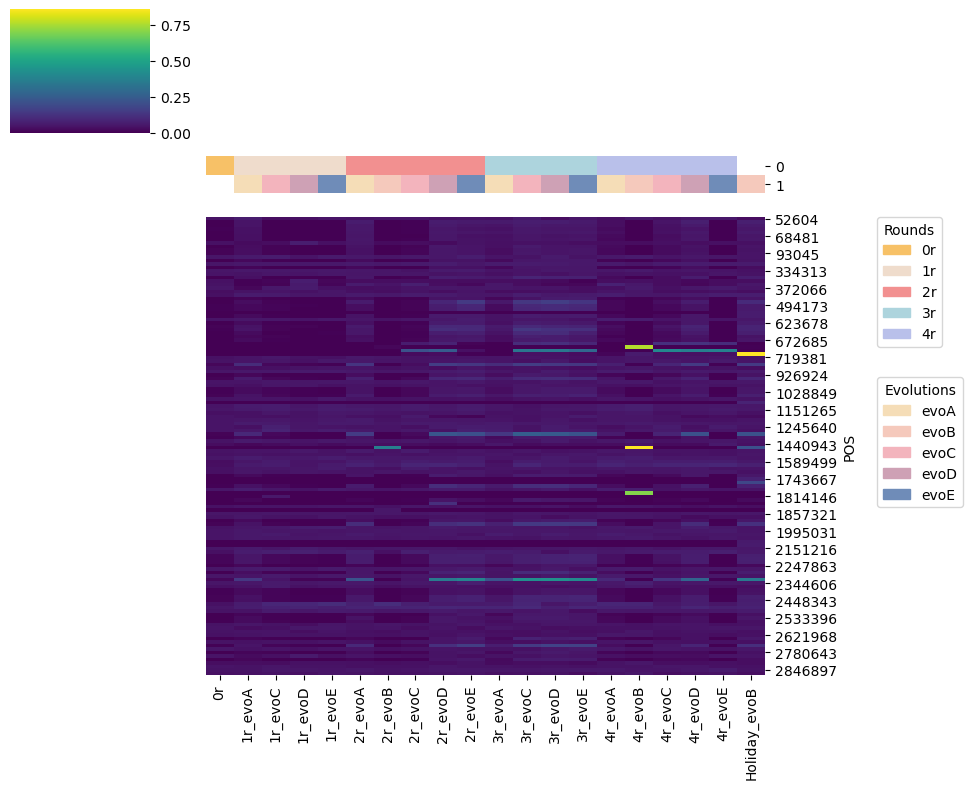

In [7]:
import matplotlib.patches as mpatches
# Extract labels from column names
round_labels = [c.split('_')[0] for c in mat.columns]
evo_labels   = [c.split('_')[-1] for c in mat.columns]

# Define palettes
round_palette = {'0r':'#F7C167', '1r':"#EFDCCC", '2r': '#F29090', '3r': '#ADD4DD', '4r':'#B9C0EA'}
evo_palette   = {'evoA':'#F5DDB7', 'evoB':'#F5C9BC',
                 'evoC':'#F3B4BD', 'evoD':'#CEA1B5', 'evoE':'#6F8CB8'}

round_colors = pd.Series(round_labels, index=mat.columns).map(round_palette)
evo_colors   = pd.Series(evo_labels, index=mat.columns).map(evo_palette)

col_colors = pd.concat([round_colors, evo_colors], axis=1)

# draw
g = sns.clustermap(mat, col_colors=col_colors, cmap="viridis", figsize=(10,8),
                   row_cluster=False, col_cluster=False)

# make space on the right for legends
g.fig.subplots_adjust(right=0.82)

# legend handles
round_patches = [mpatches.Patch(color=c, label=lab) for lab, c in round_palette.items()]
evo_patches   = [mpatches.Patch(color=c, label=lab) for lab, c in evo_palette.items()]

# add BOTH legends to the HEATMAP axis
leg1 = g.ax_heatmap.legend(handles=round_patches, title="Rounds",
                           loc="upper left", bbox_to_anchor=(1.2, 1.00),
                           borderaxespad=0.)
# IMPORTANT: re-attach the first legend so it persists
g.ax_heatmap.add_artist(leg1)

g.ax_heatmap.legend(handles=evo_patches, title="Evolutions",
                    loc="upper left", bbox_to_anchor=(1.2, 0.65),
                    borderaxespad=0.)
plt.tight_layout()
plt.savefig("all_evolutions_heatmap.pdf")

/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_3935/3404830800.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


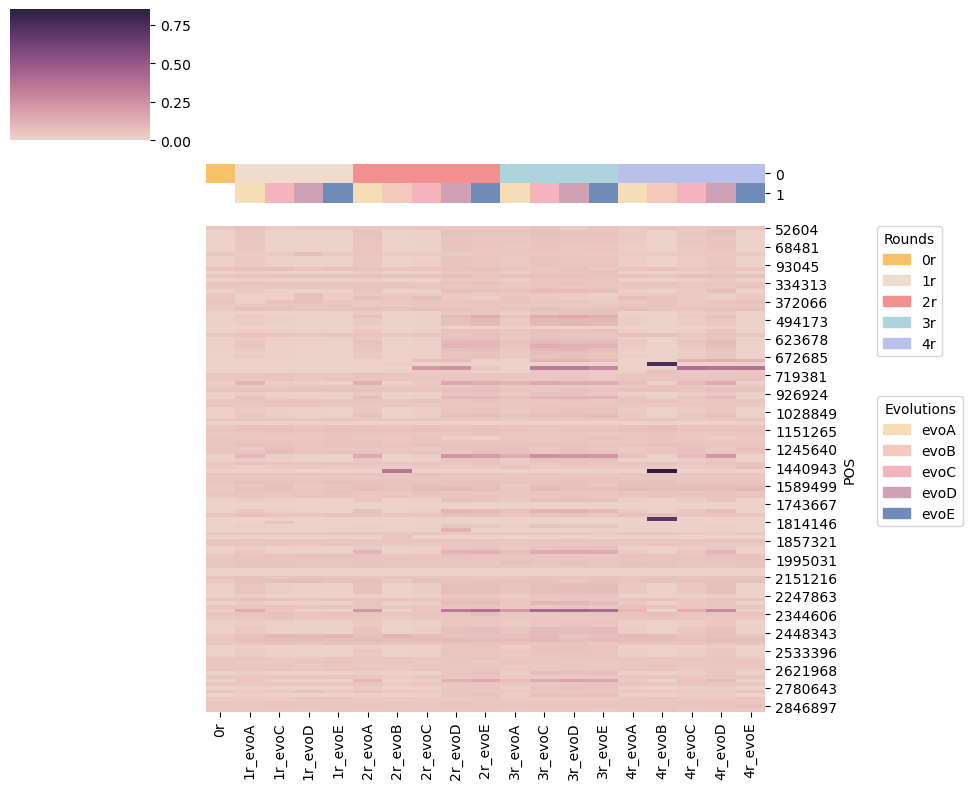

In [ ]:
mat = mat.iloc[:,0:19]
# Extract labels from column names
round_labels = [c.split('_')[0] for c in mat.columns]
evo_labels   = [c.split('_')[-1] for c in mat.columns]

# Define palettes
round_palette = {'0r':'#F7C167', '1r':"#EFDCCC", '2r': '#F29090', '3r': '#ADD4DD', '4r':'#B9C0EA'}
evo_palette   = {'evoA':'#F5DDB7', 'evoB':'#F5C9BC',
                 'evoC':'#F3B4BD', 'evoD':'#CEA1B5', 'evoE':'#6F8CB8'}

round_colors = pd.Series(round_labels, index=mat.columns).map(round_palette)
evo_colors   = pd.Series(evo_labels, index=mat.columns).map(evo_palette)

col_colors = pd.concat([round_colors, evo_colors], axis=1)

# draw
g = sns.clustermap(mat, col_colors=col_colors, cmap=sns.cubehelix_palette(as_cmap=True), figsize=(10,8),
                   row_cluster=False, col_cluster=False, linewidths=0.0)

# make space on the right for legends
g.fig.subplots_adjust(right=0.82)

# legend handles
round_patches = [mpatches.Patch(color=c, label=lab) for lab, c in round_palette.items()]
evo_patches   = [mpatches.Patch(color=c, label=lab) for lab, c in evo_palette.items()]

# add BOTH legends to the HEATMAP axis
leg1 = g.ax_heatmap.legend(handles=round_patches, title="Rounds",
                           loc="upper left", bbox_to_anchor=(1.2, 1.00),
                           borderaxespad=0.)
# IMPORTANT: re-attach the first legend so it persists
g.ax_heatmap.add_artist(leg1)

g.ax_heatmap.legend(handles=evo_patches, title="Evolutions",
                    loc="upper left", bbox_to_anchor=(1.2, 0.65),
                    borderaxespad=0.)
plt.tight_layout()
plt.savefig("evolutions_heatmap_01234.pdf")

In [10]:
mat.iloc[:,0:19]

,1r_evoA,2r_evoA,3r_evoA,4r_evoA,2r_evoB,4r_evoB,Holiday_evoB,1r_evoC,2r_evoC,3r_evoC,4r_evoC,1r_evoD,2r_evoD,3r_evoD,4r_evoD,1r_evoE,2r_evoE,3r_evoE,4r_evoE
POS,,,,,,,,,,,,,,,,,,,
52604,0.063830,0.041597,0.038737,0.034003,0.045949,0.053846,0.027287,0.031447,0.046875,0.057437,0.040367,0.034954,0.040067,0.033083,0.050590,0.043742,0.041946,0.047218,0.052229
61745,0.046356,0.066257,0.059736,0.031880,0.000526,0.001030,0.072642,0.001300,0.005792,0.069377,0.045607,0.000622,0.064163,0.067316,0.070905,0.000513,0.059790,0.058145,0.000291
62324,0.044624,0.056446,0.044112,0.030250,0.000000,0.002006,0.058684,0.000830,0.005405,0.060695,0.037991,0.001995,0.059216,0.056114,0.058837,0.000212,0.049698,0.054476,0.000000
68194,0.038941,0.055689,0.038229,0.025136,0.000702,0.000877,0.052688,0.000218,0.005221,0.054008,0.034030,0.000521,0.052939,0.049201,0.045574,0.000453,0.042821,0.049037,0.000000
68310,0.039701,0.053157,0.045618,0.031012,0.002003,0.002339,0.057525,0.000474,0.005256,0.054772,0.039609,0.001427,0.054684,0.051570,0.055046,0.000705,0.048519,0.054533,0.000811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835831,0.015012,0.011981,0.021946,0.006988,0.000000,0.000248,0.032124,0.003065,0.005446,0.063360,0.016279,0.001564,0.044321,0.064875,0.019511,0.001098,0.055789,0.060317,0.000295
2841486,0.031921,0.036648,0.024664,0.043354,0.032449,0.052290,0.032676,0.029438,0.034091,0.031501,0.030442,0.039330,0.032157,0.032135,0.033468,0.038274,0.041291,0.025875,0.036802
2846886,0.041174,0.036389,0.040857,0.040755,0.039724,0.040323,0.038319,0.050032,0.038146,0.038991,0.048746,0.040478,0.047146,0.042920,0.047345,0.041597,0.043302,0.039732,0.039957


/var/folders/51/n69nfv650kj287fzxg37b8r80000gn/T/ipykernel_23068/649978706.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


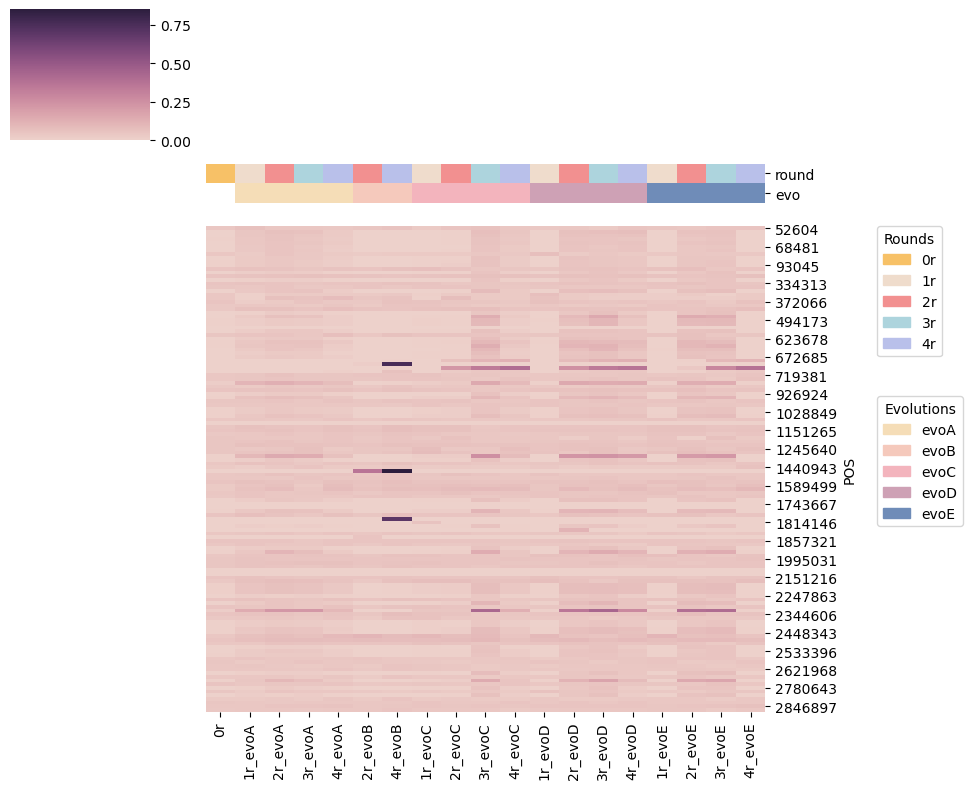

In [41]:
mat = mat.iloc[:, 0:19]  # if you still want just the first 19
import matplotlib.patches as mpatches
# --- 1) Parse labels ---
round_labels = [c.split('_')[0] for c in mat.columns]
evo_labels   = [c.split('_')[-1] for c in mat.columns]

# Desired display order
order_rounds = ['0r','1r','2r','3r','4r']
order_evos   = ['evoA','evoB','evoC','evoD','evoE']  # or list(evo_palette.keys())

# Build a sortable table of columns
cols_df = pd.DataFrame({
    'col': mat.columns,
    'round': round_labels,
    'evo': evo_labels
})
cols_df['round'] = pd.Categorical(cols_df['round'], categories=order_rounds, ordered=True)
cols_df['evo']   = pd.Categorical(cols_df['evo'],   categories=order_evos,   ordered=True)

# --- 2) Reorder columns: group by experiment (evo), then by round ---
new_cols = cols_df.sort_values(['evo','round'])['col'].tolist()
new_cols = (['0r'] if '0r' in new_cols else []) + [c for c in new_cols if c != '0r'] #make 0r first
mat = mat.loc[:, new_cols]

# --- 3) Rebuild color annotations in the same new order ---
round_palette = {'0r':'#F7C167', '1r':"#EFDCCC", '2r': '#F29090', '3r': '#ADD4DD', '4r':'#B9C0EA'}
evo_palette   = {'evoA':'#F5DDB7', 'evoB':'#F5C9BC', 'evoC':'#F3B4BD', 'evoD':'#CEA1B5', 'evoE':'#6F8CB8'}

round_colors = cols_df.set_index('col').loc[new_cols, 'round'].map(round_palette)
evo_colors   = cols_df.set_index('col').loc[new_cols, 'evo'].map(evo_palette)
col_colors   = pd.concat([round_colors, evo_colors], axis=1)

# --- 4) Plot (unchanged logic) ---
g = sns.clustermap(mat, col_colors=col_colors,
                   cmap=sns.cubehelix_palette(as_cmap=True),
                   figsize=(10,8),
                   row_cluster=False, col_cluster=False, linewidths=0.0)

g.fig.subplots_adjust(right=0.82)

round_patches = [mpatches.Patch(color=c, label=lab) for lab, c in round_palette.items()]
evo_patches   = [mpatches.Patch(color=c, label=lab) for lab, c in evo_palette.items()]

leg1 = g.ax_heatmap.legend(handles=round_patches, title="Rounds",
                           loc="upper left", bbox_to_anchor=(1.2, 1.00),
                           borderaxespad=0.)
g.ax_heatmap.add_artist(leg1)
g.ax_heatmap.legend(handles=evo_patches, title="Evolutions",
                    loc="upper left", bbox_to_anchor=(1.2, 0.65),
                    borderaxespad=0.)

plt.tight_layout()
plt.savefig("evolutions_reorder_heatmap_01234.pdf")
plt.show()


In [40]:
new_cols


['1r_evoA',
 '2r_evoA',
 '3r_evoA',
 '4r_evoA',
 '2r_evoB',
 '4r_evoB',
 '1r_evoC',
 '2r_evoC',
 '3r_evoC',
 '4r_evoC',
 '1r_evoD',
 '2r_evoD',
 '3r_evoD',
 '4r_evoD',
 '1r_evoE',
 '2r_evoE',
 '3r_evoE',
 '4r_evoE',
 '0r']

In [29]:
new_cols

['0r',
 '1r_evoA',
 '1r_evoC',
 '1r_evoD',
 '1r_evoE',
 '2r_evoA',
 '2r_evoB',
 '2r_evoC',
 '2r_evoD',
 '2r_evoE',
 '3r_evoA',
 '3r_evoC',
 '3r_evoD',
 '3r_evoE',
 '4r_evoA',
 '4r_evoB',
 '4r_evoC',
 '4r_evoD',
 '4r_evoE']

In [10]:
mat.iloc[:,0:19]

,0r,1r_evoA,1r_evoC,1r_evoD,1r_evoE,2r_evoA,2r_evoB,2r_evoC,2r_evoD,2r_evoE,3r_evoA,3r_evoC,3r_evoD,3r_evoE,4r_evoA,4r_evoB,4r_evoC,4r_evoD,4r_evoE
POS,,,,,,,,,,,,,,,,,,,
52604,0.041591,0.063830,0.031447,0.034954,0.043742,0.041597,0.045949,0.046875,0.040067,0.041946,0.038737,0.057437,0.033083,0.047218,0.034003,0.053846,0.040367,0.050590,0.052229
61745,0.001519,0.046356,0.001300,0.000622,0.000513,0.066257,0.000526,0.005792,0.064163,0.059790,0.059736,0.069377,0.067316,0.058145,0.031880,0.001030,0.045607,0.070905,0.000291
62324,0.002122,0.044624,0.000830,0.001995,0.000212,0.056446,0.000000,0.005405,0.059216,0.049698,0.044112,0.060695,0.056114,0.054476,0.030250,0.002006,0.037991,0.058837,0.000000
68194,0.003530,0.038941,0.000218,0.000521,0.000453,0.055689,0.000702,0.005221,0.052939,0.042821,0.038229,0.054008,0.049201,0.049037,0.025136,0.000877,0.034030,0.045574,0.000000
68310,0.002147,0.039701,0.000474,0.001427,0.000705,0.053157,0.002003,0.005256,0.054684,0.048519,0.045618,0.054772,0.051570,0.054533,0.031012,0.002339,0.039609,0.055046,0.000811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835831,0.002102,0.015012,0.003065,0.001564,0.001098,0.011981,0.000000,0.005446,0.044321,0.055789,0.021946,0.063360,0.064875,0.060317,0.006988,0.000248,0.016279,0.019511,0.000295
2841486,0.031892,0.031921,0.029438,0.039330,0.038274,0.036648,0.032449,0.034091,0.032157,0.041291,0.024664,0.031501,0.032135,0.025875,0.043354,0.052290,0.030442,0.033468,0.036802
2846886,0.045127,0.041174,0.050032,0.040478,0.041597,0.036389,0.039724,0.038146,0.047146,0.043302,0.040857,0.038991,0.042920,0.039732,0.040755,0.040323,0.048746,0.047345,0.039957


## SAUSA300_RS03310

In [12]:
df[df['Gene_ID']=='SAUSA300_RS03310']

,POS,REF,ALT,QUAL,9_RO,9_AO,7_RO,7_AO,6_RO,6_AO,...,3_ratio,2_ratio,20_ratio,10_ratio,14_ratio,8_ratio,16_ratio,19_ratio,17_ratio,Gene_ID
124,688558,GTGATGATGAT,GTGATGATGATGAT,5.893970e-12,4871.0,0.0,4877,44,4254.0,0.0,...,0.000000,0.0,0.110524,0.000000,0.009483,0.000252,0.114502,0.124209,0.092064,SAUSA300_RS03310
125,689075,G,T,7.667720e+04,4164.0,0.0,1016,3192,3639.0,57.0,...,0.000251,0.0,0.000277,0.000000,0.000000,0.004560,0.000000,0.000280,0.000000,SAUSA300_RS03310
126,689161,GTTTTTTCA,GTTTTTTTCA,2.456330e-11,4820.0,1.0,4749,0,4184.0,1.0,...,0.000000,0.0,0.375342,0.002353,0.035190,0.000000,0.342786,0.368515,0.285302,SAUSA300_RS03310
127,689341,CAAAAAATGATGACTA,CAA,6.232030e+04,4357.0,2.0,3955,256,3773.0,8.0,...,0.000000,0.0,0.038597,0.000289,0.004156,0.857841,0.037777,0.036748,0.027075,SAUSA300_RS03310


In [14]:
mat

,0r,1r_evoA,1r_evoC,1r_evoD,1r_evoE,2r_evoA,2r_evoB,2r_evoC,2r_evoD,2r_evoE,3r_evoA,3r_evoC,3r_evoD,3r_evoE,4r_evoA,4r_evoB,4r_evoC,4r_evoD,4r_evoE,Holiday_evoB
POS,,,,,,,,,,,,,,,,,,,,
52604,0.041591,0.063830,0.031447,0.034954,0.043742,0.041597,0.045949,0.046875,0.040067,0.041946,0.038737,0.057437,0.033083,0.047218,0.034003,0.053846,0.040367,0.050590,0.052229,0.027287
61745,0.001519,0.046356,0.001300,0.000622,0.000513,0.066257,0.000526,0.005792,0.064163,0.059790,0.059736,0.069377,0.067316,0.058145,0.031880,0.001030,0.045607,0.070905,0.000291,0.072642
62324,0.002122,0.044624,0.000830,0.001995,0.000212,0.056446,0.000000,0.005405,0.059216,0.049698,0.044112,0.060695,0.056114,0.054476,0.030250,0.002006,0.037991,0.058837,0.000000,0.058684
68194,0.003530,0.038941,0.000218,0.000521,0.000453,0.055689,0.000702,0.005221,0.052939,0.042821,0.038229,0.054008,0.049201,0.049037,0.025136,0.000877,0.034030,0.045574,0.000000,0.052688
68310,0.002147,0.039701,0.000474,0.001427,0.000705,0.053157,0.002003,0.005256,0.054684,0.048519,0.045618,0.054772,0.051570,0.054533,0.031012,0.002339,0.039609,0.055046,0.000811,0.057525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2835831,0.002102,0.015012,0.003065,0.001564,0.001098,0.011981,0.000000,0.005446,0.044321,0.055789,0.021946,0.063360,0.064875,0.060317,0.006988,0.000248,0.016279,0.019511,0.000295,0.032124
2841486,0.031892,0.031921,0.029438,0.039330,0.038274,0.036648,0.032449,0.034091,0.032157,0.041291,0.024664,0.031501,0.032135,0.025875,0.043354,0.052290,0.030442,0.033468,0.036802,0.032676
2846886,0.045127,0.041174,0.050032,0.040478,0.041597,0.036389,0.039724,0.038146,0.047146,0.043302,0.040857,0.038991,0.042920,0.039732,0.040755,0.040323,0.048746,0.047345,0.039957,0.038319


In [13]:
mat.loc[688558]

0r              0.000000
1r_evoA         0.000000
1r_evoC         0.000000
1r_evoD         0.000000
1r_evoE         0.000215
2r_evoA         0.000000
2r_evoB         0.000000
2r_evoC         0.065487
2r_evoD         0.083060
2r_evoE         0.009483
3r_evoA         0.000000
3r_evoC         0.105710
3r_evoD         0.114502
3r_evoE         0.092064
4r_evoA         0.000390
4r_evoB         0.008941
4r_evoC         0.120237
4r_evoD         0.124209
4r_evoE         0.110524
Holiday_evoB    0.000252
Name: 688558, dtype: float64

In [32]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_row_as_curves(mat, row_index, colors=None, outfile=None):
    """
    Plot one row of `mat` as multiple evo curves sharing the same 0r start.

    colors: dict like {'evoA':'#F5DDB7', 'evoB':'#F5C9BC', ...}
    outfile: if provided (e.g. 'row_688558.pdf'), the figure is saved as a PDF
    """
    # 1) grab the row
    row = mat.loc[row_index]
    if '0r' not in row.index:
        raise ValueError("Column '0r' not found. Include a baseline column named exactly '0r'.")
    base0 = float(row['0r'])

    # 2) parse columns like '1r_evoA' -> (time='1r', evo='A')
    long_records = []
    pat = re.compile(r'^(\d+r)_evo([A-Za-z0-9]+)$')
    for col, val in row.items():
        m = pat.match(col)
        if m:
            time, evo = m.group(1), m.group(2)
            long_records.append({'time': time, 'evo': evo, 'value': float(val)})

    if not long_records:
        raise ValueError("No columns matched the pattern '<Nr>_evoX' (e.g., '1r_evoA').")

    df = pd.DataFrame(long_records)

    # 3) ensure each evo has the shared 0r starting point
    evos = sorted(df['evo'].unique(), key=lambda x: (len(str(x)), str(x)))
    zero_rows = [{'time': '0r', 'evo': e, 'value': base0} for e in evos]
    df = pd.concat([pd.DataFrame(zero_rows), df], ignore_index=True)

    # 4) order times numerically (0r,1r,2r,3r,4r,...)
    def time_key(t): return int(t.split('r')[0])
    times = sorted(df['time'].unique(), key=time_key)
    x_pos = {t:i for i,t in enumerate(times)}

    # 5) plot with custom colors
    plt.figure(figsize=(6,4))
    for e in evos:
        sub = df[df['evo'] == e].copy()
        sub['x'] = sub['time'].map(x_pos)
        sub = sub.sort_values('x').dropna(subset=['value'])

        label = f"evo{e}"
        color = None
        if colors:
            color = colors.get(label, None)  # use provided color if available

        plt.plot(
            sub['x'], sub['value'],
            marker='o', linewidth=2,
            label=label,
            color=color  # matplotlib will pick default if None
        )

    plt.xticks(range(len(times)), times)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.title(f"Row {row_index}: per-evo curves (shared 0r start)")
    leg = plt.legend(title="Lineage", frameon=False)
    plt.tight_layout()

    # 6) save to PDF if requested
    if outfile:
        plt.savefig(outfile, bbox_inches='tight')
        print(f"Saved figure to {outfile}")

    plt.show()

# ---- example usage ----
colors = {
    'evoA':'#F5DDB7',
    'evoB':'#F5C9BC',
    'evoC':'#F3B4BD',
    'evoD':'#CEA1B5',
    'evoE':'#6F8CB8',
}
# plot_row_as_curves(mat, 688558, colors=colors, outfile='row_688558.pdf')


Saved figure to 688558curve.pdf


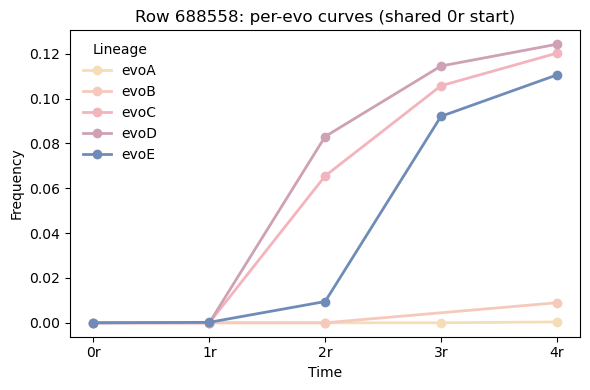

In [33]:
plot_row_as_curves(mat.iloc[:,0:19], 688558, colors=colors, outfile='688558curve.pdf')

Saved figure to 689161curve.pdf


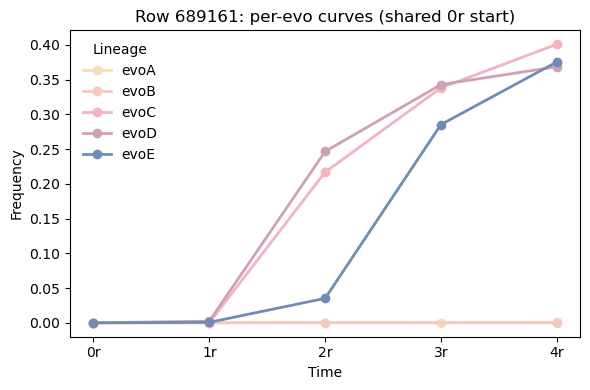

In [34]:
plot_row_as_curves(mat.iloc[:,0:19], 689161, colors=colors, outfile='689161curve.pdf')

Saved figure to 689341curve.pdf


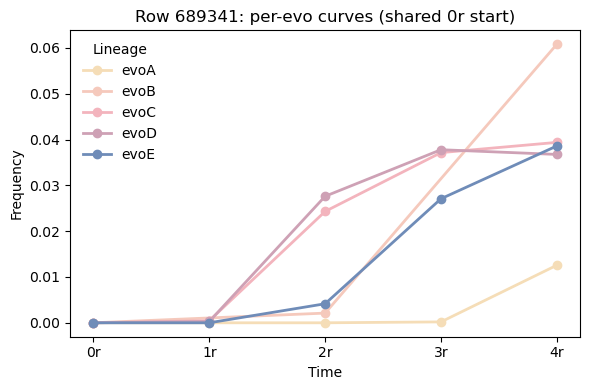

In [35]:
plot_row_as_curves(mat.iloc[:,0:19], 689341, colors=colors, outfile='689341curve.pdf')